In [1]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions

from importlib import reload

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_seconds = 86400

## Looking for ETVs in TIC 160710406 (EB2)


In [3]:
# define the plotting parameters

figsize = (8,4)

SearchResult containing 3 data products.

 #     mission     year author exptime target_name distance proposal_id
                                  s                 arcsec             
--- -------------- ---- ------ ------- ----------- -------- -----------
  0 TESS Sector 11 2019    QLP    1800   160710406      0.0         N/A
  1 TESS Sector 38 2021    QLP     600   160710406      0.0         N/A
  2 TESS Sector 65 2023    QLP     200   160710406      0.0         N/A

16597


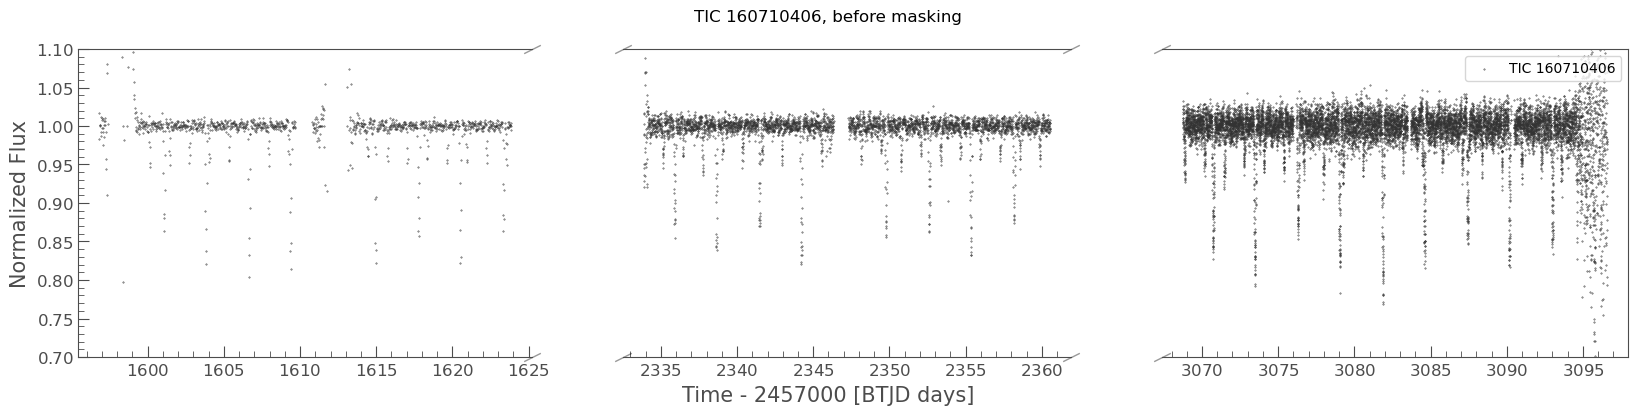

In [22]:
# import the data

# choose a TIC ID to analyze
ticid = 160710406

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import tic_plot as tplt

sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC', 'QLP'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
with astropy.conf.set_temp("max_lines", -1):
    display(sr)
lcc_tess = sr.download_all()

def use_sap_flux(lc):
    """Helper over select_flux("sap_flux") to ensure flux_err is populated for QLP case"""
    if lc.meta.get("AUTHOR") == "QLP":
        # select_flux("sap_flux") on QLP data will lead to nan flux_err
        # because QLP lc only has err on kspsap_flux / det_flux
        return lc
    else:
        return lc.select_flux("sap_flux")
lc_tess_unfiltered = lcc_tess.stitch(
    corrector_func=lambda lc: lke.select_flux(lc, ["kspsap_flux", "det_flux"])
)
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now

axs = tplt.plot_skip_data_gap(lc_tess_unfiltered, s=0.5, figsize=(20, 4));
axs[0].get_figure().suptitle(f"{lc.label}, before masking");
[ax.set_ylim(0.7, 1.1) for ax in axs];

print(len(lc_tess_unfiltered))

14093

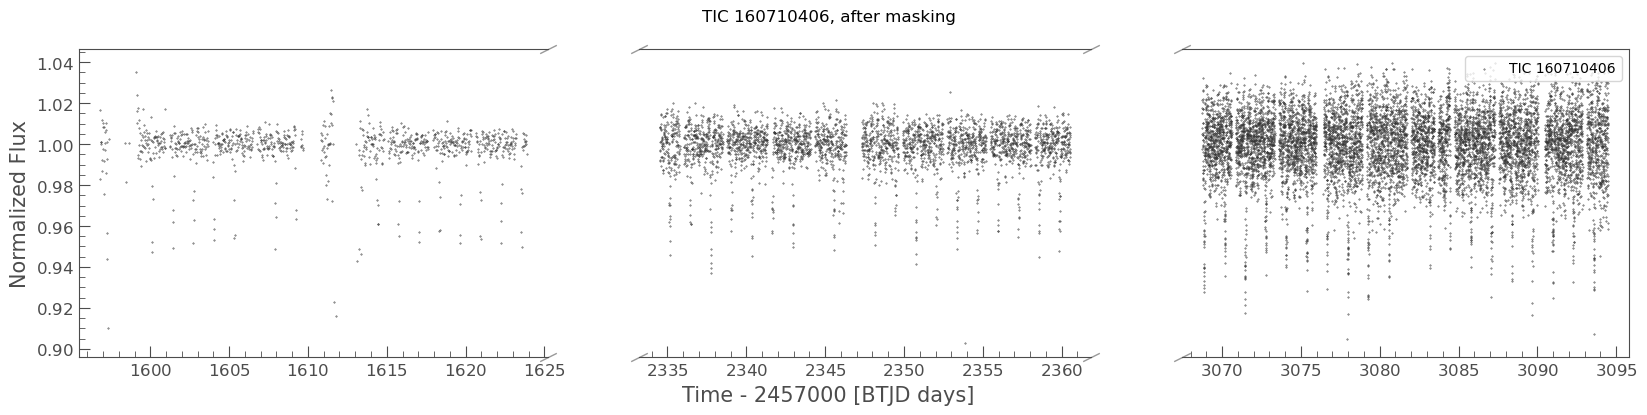

In [25]:
%matplotlib inline
# %matplotlib ipympl

# filter out unwanted cadences
lc = lc_tess_unfiltered

# filter out EB1
eb1_specs = lke.TransitTimeSpecList(  # TIC 160710406
    dict(epoch=3073.47, duration_hr=4.2, period=5.56685, label="EB1deep",
         # sector=65, steps_to_show=[0],
        ),
    dict(epoch=3076.30, duration_hr=4.2, period=5.56685, label="EB1shallow",  # phase +2.83d, or 0.508 normalized
         # sector=65, steps_to_show=[0],
        ),
    # dict(epoch=3071.47, duration_hr=2.5, period=1.30092, label="EB2all",
    #      sector=65, steps_to_show=[3],
    #     ),
    defaults=dict(surround_time=1.0)
)

duration_factor = 1.5
tmask = lc.create_transit_mask(transit_time=eb1_specs.epoch, period=eb1_specs.period, duration=eb1_specs.duration * duration_factor)
lc = lc[~tmask]

lc = lke.exclude_range(lc, 2333, 2334.5)  # scattered light
lc = lke.exclude_range(lc, 3094.5, 3098)  # data clearly not usable

# filter out flux outliers
lc = lc.truncate(0.8, 1.04, column="flux")


axs = tplt.plot_skip_data_gap(lc, s=0.5, figsize=(20, 4));
axs[0].get_figure().suptitle(f"{lc.label}, after masking");
# [ax.set_ylim(0.7, 1.1) for ax in axs];


#
# assign the filtered dout to globals for subsequent use
#
lc_tess = lc
search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
data = pd.DataFrame({'time': time, 'flux': flux, 'err': fluxerr})

len(search_result)

### Conisderable out of eclipse variation

- Considerable out of eclipse oscillation that would affect ETV accuracy

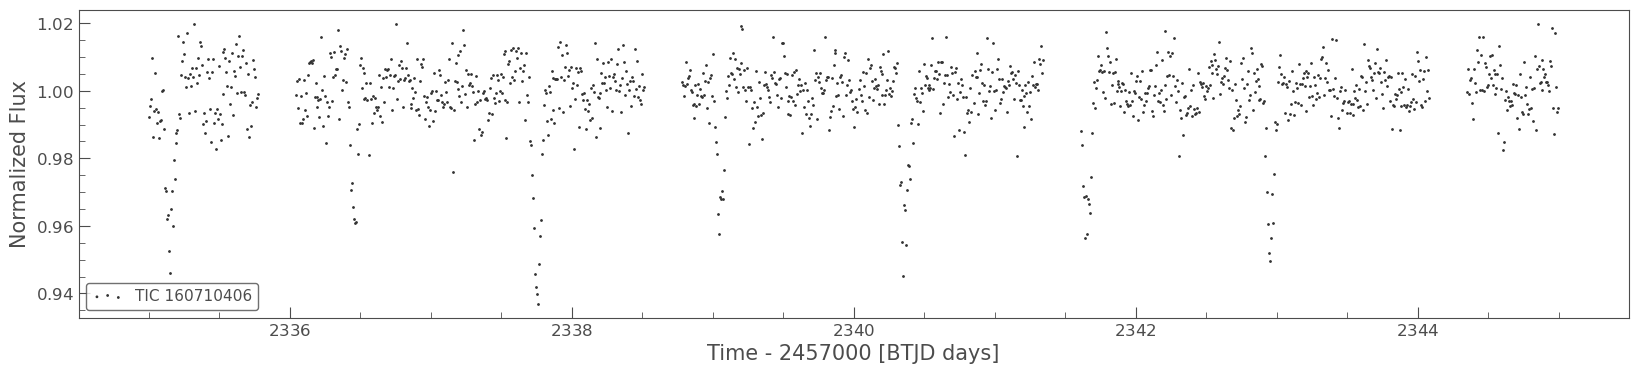

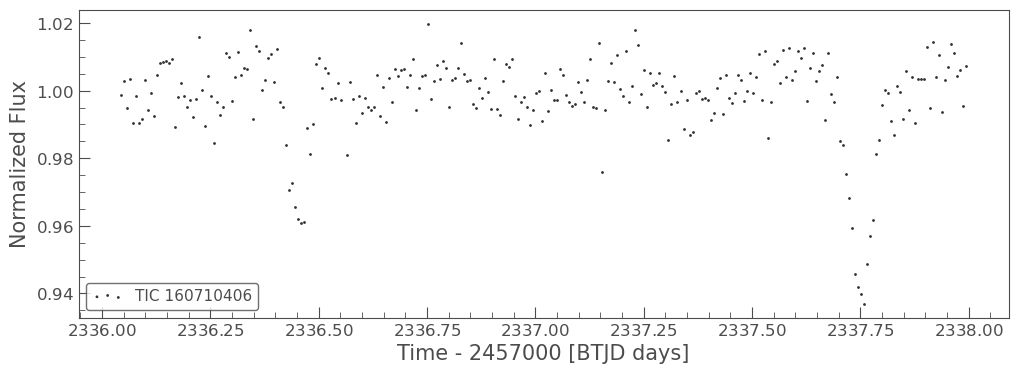

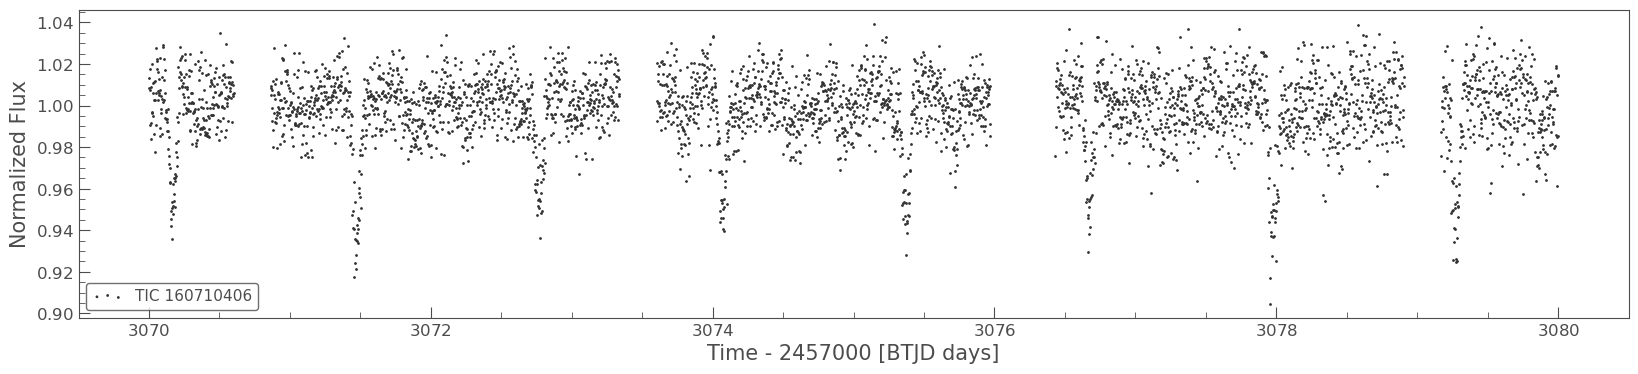

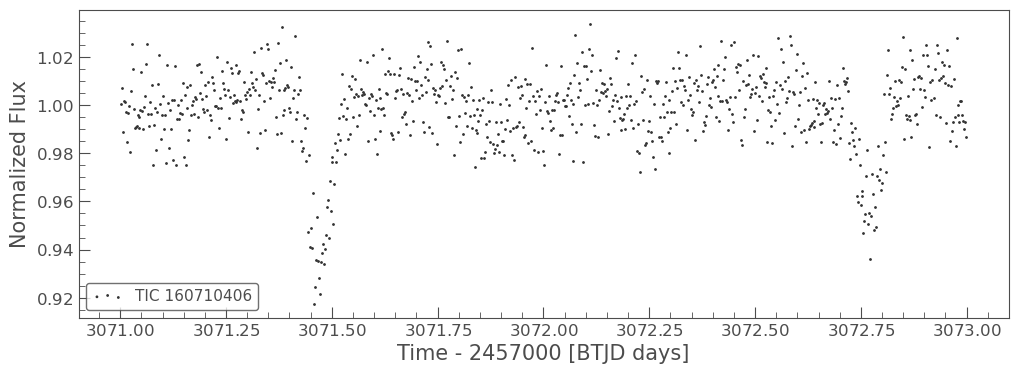

In [65]:
ax = tplt.scatter(lc_tess.truncate(2335, 2345), figsize=(20, 4));
ax = tplt.scatter(lc_tess.truncate(2336, 2338), figsize=(12, 4));  # further zoom-in

ax = tplt.scatter(lc_tess.truncate(3070, 3080), figsize=(20, 4));
ax = tplt.scatter(lc_tess.truncate(3071, 3073), figsize=(12, 4));   # further zoom-in


#### Tried to subtract the out of eclipse oscillation but failed

In [66]:
pg = lc_tess.to_periodogram(method="ls")
pg.show_properties();

lightkurve.Periodogram properties:
      Attribute                   Description            Units
---------------------- --------------------------------- -----
                nterms                                 1      
              targetid                         160710406      
          default_view                         frequency      
                 label                     TIC 160710406      
             ls_method                              fast      
frequency_at_max_power                            3.0747 1 / d
             max_power                            0.0049      
               nyquist                          215.9976 1 / d
   period_at_max_power                            0.3252     d
             frequency                  array (1617488,) 1 / d
                period                  array (1617488,)     d
                 power                  array (1617488,)      
                  meta <class 'collections.OrderedDict'>      


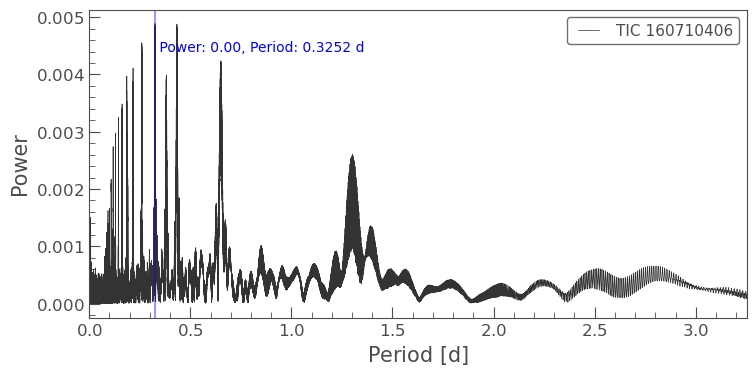

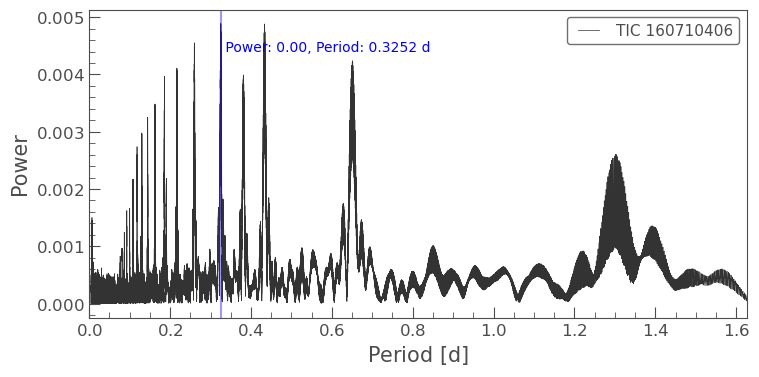

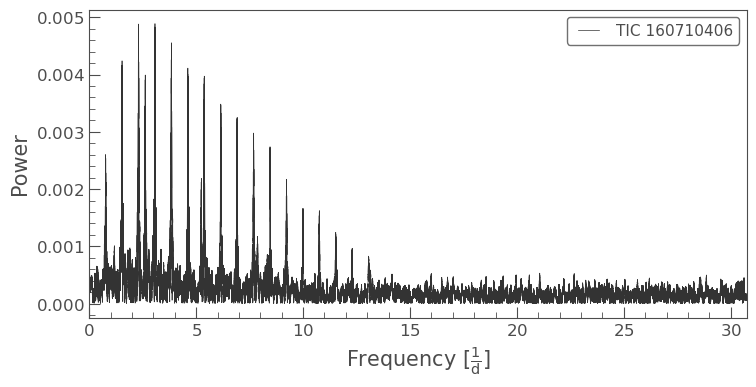

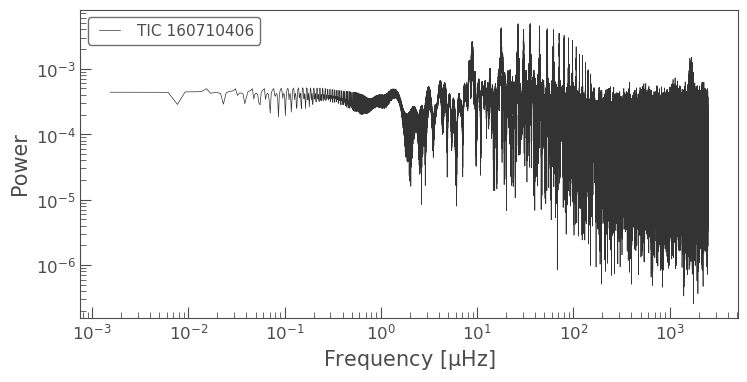

In [70]:
import lightkurve_ext_pg as  lke_pg

ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=10);
# ax.set_xlim(0, 16);

# zoom in
ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=5);

# ---

ax = pg.plot(view="frequency", alpha=0.7);  # frequency view
ax.set_xlim(0 , pg.frequency_at_max_power.value * 10);
# ax.set_xlim(0, 5);

for i in range(1, 10):
    pg.axvline(pg.frequency_at_max_power.value, color="blue", linestye="--");

# frequency in log scale / microhertz
# often useful for solar type oscillator, 
ax = pg.plot(view="frequency", unit=u.microhertz, scale="log");

# the smoothed plot is useful for repsresenting convective background (that scientists usually want to filter out)
# smooth_pg = pg.smo7oth(method='logmedian', filter_width=0.1)
# smooth_pg.plot(ax=ax, linewidth=2,  color='red', label='Smoothed (bkg)', unit=u.microhertz, scale='log');
# ax.axvline(50.31207607657116, ymax=0.2, color="blue", linestyle="--", label="~50 uHz "); ax.legend();



In [126]:
# reload(lke_pg)
peaks = lke_pg.find_peaks(
    pg, 
    # pg[pg.frequency < 500 * u.microhertz], 
    powerlimit=10**-4,   
)
if "period" not in peaks.columns:
    peaks["period"] = 1 / peaks["frequency"]
    peaks["period"].unit = 1 / peaks["frequency"].unit
if "frequency" not in peaks.columns:
    peaks["frequency"] = 1 / peaks["period"]
    peaks["frequency"].unit = 1 / peaks["period"].unit
peaks["frequency_u"] = u.Quantity(peaks["frequency"]).to(u.microhertz)  # in microhertz, for log scale plot
peaks["period_h"] = u.Quantity(peaks["period"]).to(u.hour)  # period in hours
peaks["rank"] = np.linspace(1, len(peaks), len(peaks), dtype=int)
peaks["frequency_ratio2"] = peaks["frequency"] / (pg.frequency_at_max_power.value  / 4)

# peaks[peaks["frequency"] > 100][:15]  # in 1/d
# peaks[peaks["frequency_u"] > 200][:15]
# peaks[peaks["frequency_ratio"] < 5][:15]
peaks[peaks["period"] > 0][:20]

<Table length=20>
        power             frequency      ...  rank  frequency_ratio2 
                            1 / d        ...             1 / d       
       float64             float64       ... int32      float64      
--------------------- ------------------ ... ----- ------------------
 0.004887875432022728 3.0747311049847177 ...     1                4.0
 0.004879620520206634   2.30608171344109 ...     2 3.0000434310532036
0.0045514847795120545 3.8420451084262894 ...     3  4.998219326818676
0.0042387162877937186 1.5359633949851998 ...     4 1.9981758957654725
 0.004111308962535674  4.612163426882179 ...     5  6.000086862106406
 0.003971236030557514  5.380812818425807 ...     6  7.000043431053203
0.0039911058976960625 2.6208326890957685 ...     7  3.409511400651466
0.0034833285346495173  6.149462209969435 ...     8                8.0
 0.003251581678247794  6.919580528425326 ...     9  9.001867535287731
0.0029779153244270484  7.686894531866897 ...    10 10.000086862106405
 0.002738438078827918  8.454208535308469 ...    11 10.998306188925081
0.0026026084694061383 0.7673140034415716 ...    12 0.9982193268186753
0.0021717727571627355  9.226997629968471 ...    13 12.003648208469055
 0.002186489256351701  5.243000766293593 ...    14  6.820760043431053
 0.004878580822779891  2.307417101543146 ...    15 3.0017806731813246
 0.004834545226581646 2.3047463253390337 ...    16 2.9983061889250817
 0.004735442441054781 2.3019420103247152 ...    17 2.9946579804560263
  0.00483161906296147 2.3087524896452023 ...    18  3.003517915309446
 0.004671686336340769  2.300606622222659 ...    19  2.992920738327905
 0.004880911501935337 3.0733957168826613 ...    20 3.9982627578718786

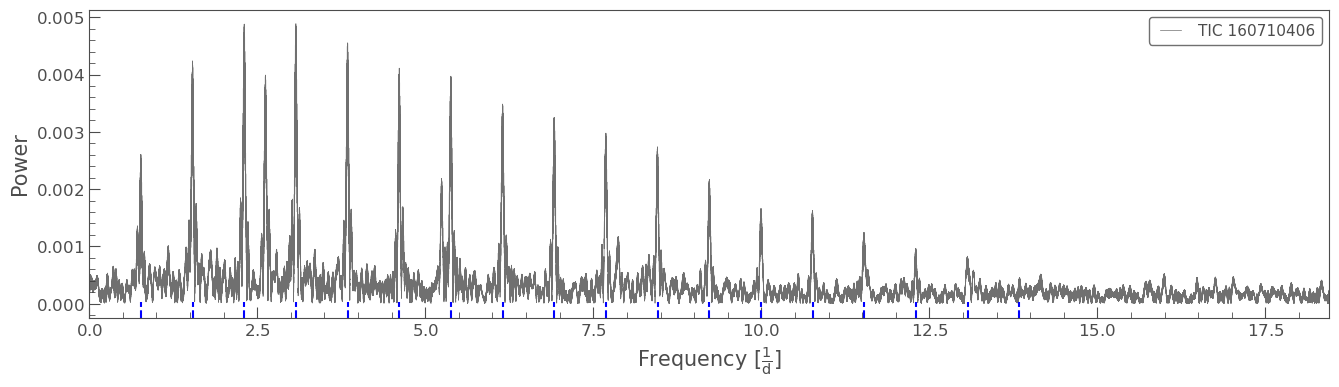

In [128]:
ax = tplt.lk_ax(figsize=(16, 4))
ax = pg.plot(view="frequency", ax=ax, alpha=0.7);  # frequency view
ax.set_xlim(0 , pg.frequency_at_max_power.value * 6);
# ax.set_xlim(0, 5);

base_freq = pg.frequency_at_max_power.value / 4
# base_freq = 0.38155812240918624  # the first peak that is not the harmonics  of pg.frequency_at_max_power.value / 4
for i in range(1, 19):
    ax.axvline(base_freq * i, ymax=0.05, color="blue", linestyle="--");


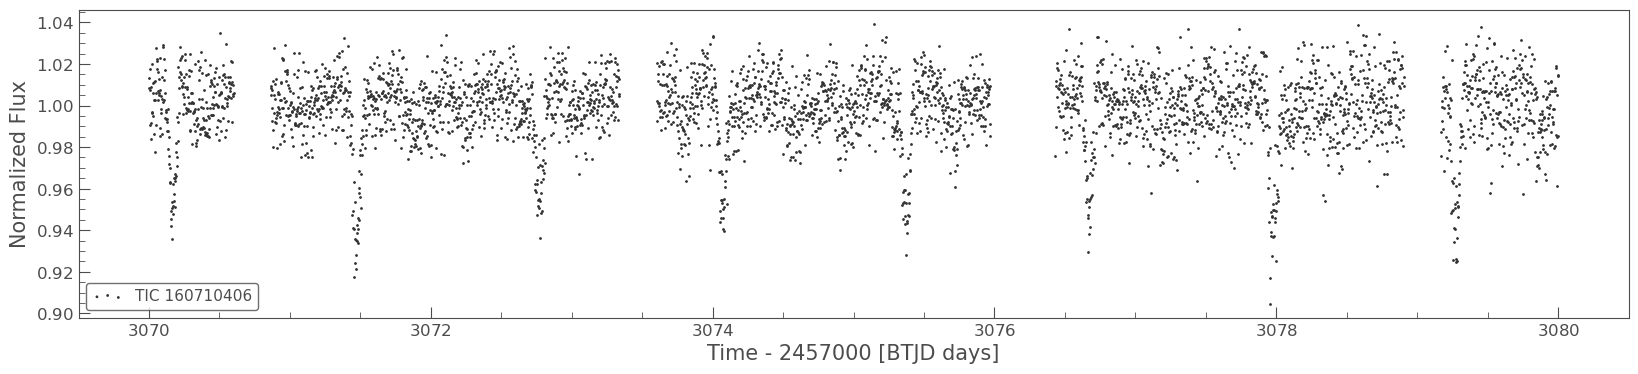

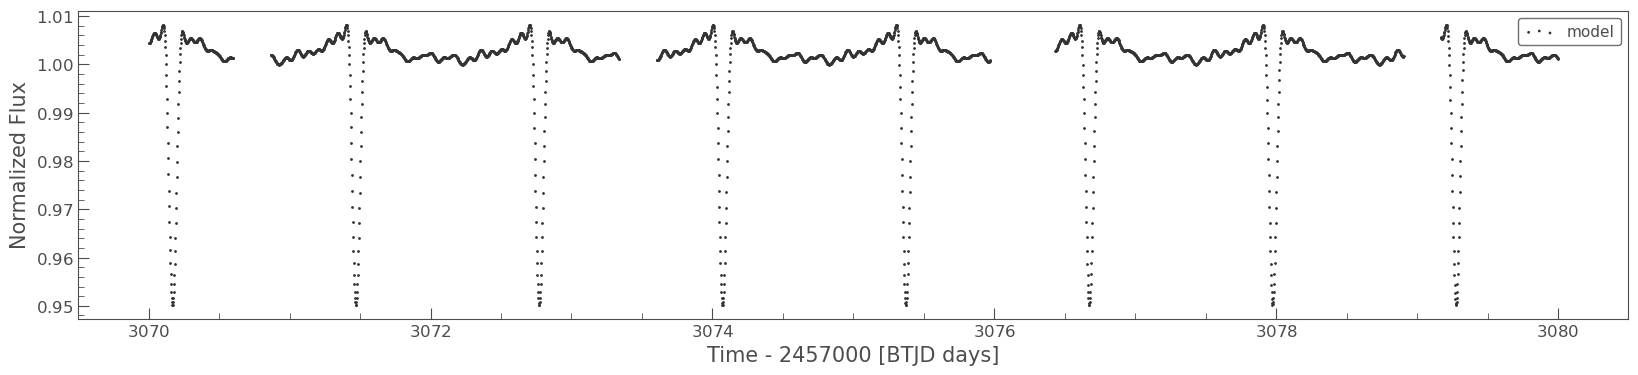

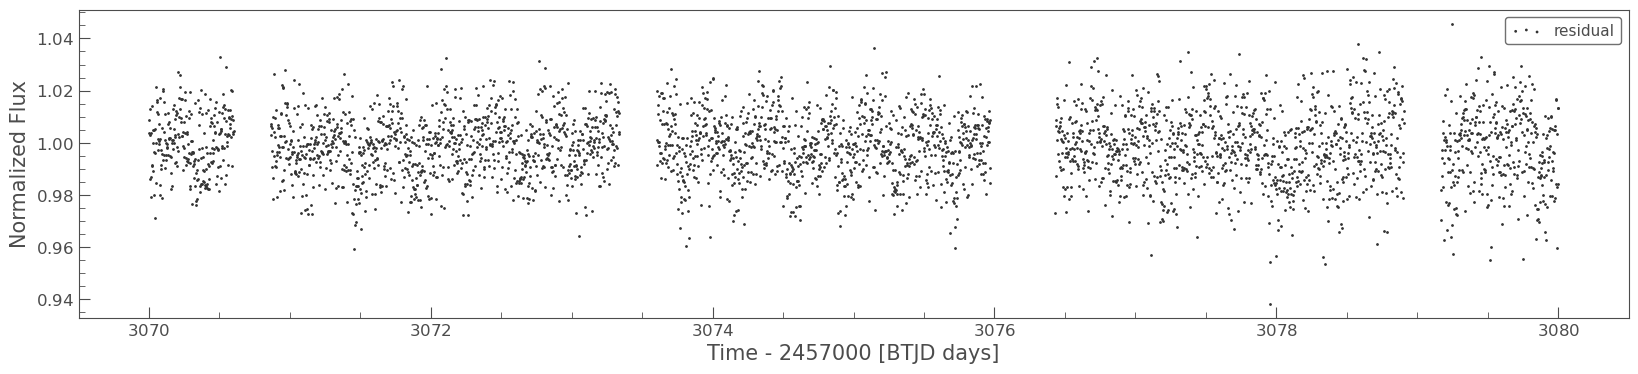

In [130]:
lc = lc_tess.truncate(3070, 3080)  # for testing

# the frequencies identified actually approximate the eclipses

freqs = np.array([ base_freq * i for i in range(1, 19) ]) * (1/u.d)
lc_model = lke_pg.create_model_lc_of_frequencies(lc, pg, freqs)
lc_residual = lc / lc_model

ax = tplt.scatter(lc, figsize=(20, 4));
ax = tplt.scatter(lc_model, figsize=(20, 4), label="model");
ax = tplt.scatter(lc_residual, figsize=(20, 4), label="residual");


In [ ]:
# %matplotlib inline
# # %matplotlib widget

# time = search_result.time.value
# flux = search_result.flux.value
# fluxerr = search_result.flux_err.value
# len(search_result)

# # mask out data you don't like...

# fig, ax = plt.subplots(figsize=figsize)
# search_result.scatter(ax = ax)

# mask = time < 0  #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data
# # mask = flux < 0.85    # remove occasional outliers
# # mask = (
# #     ( flux < 0.95 ) | # remove occasional lone outliers
# #     # cadences where scattered light effect is prevalent
# #     ( (time > 2718)   & (time < 2744) )
# # )

# time = time[~mask]
# flux = flux[~mask]
# fluxerr = fluxerr[~mask]

# # make sure that therte are no nans!

# finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# # make a dictionary of the data

# data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

# ax2 = plt.figure(figsize=figsize).gca()
# ax2.scatter(data.time, data.flux, s=0.1);
# ax2.set_ylabel(ax.get_ylabel())
# ax2.set_xlabel(ax.get_xlabel())
# ax2.set_title("After masking");

In [ ]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [ ]:
do_ls = False

if do_ls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg as lke_pg  # at ../../

    lc = lk.LightCurve(time=Time(time, format="btjd"), flux=flux, flux_err=fluxerr)
    lc.meta["LABEL"] = f"TIC {ticid}"
    pg = lc.to_periodogram(method="lombscargle",
                           # maximum_period=10,
                           # minimum_period=0.4,
                           # ls_method="fastchi2", nterms=2,
                           # oversample_factor=50,  # default: 5
                          )

    pg.show_properties();
    print(pg.period_at_max_power);

    ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=10);

    ax = pg.plot(view="frequency");  # frequency view
    ax.set_xlim(pg.frequency_at_max_power.value / 100 , pg.frequency_at_max_power.value * 10);

    ax = pg.plot(view="frequency", unit=u.microhertz, scale="log");

    axs, lcs = lke_pg.plot_lc_with_model(
        lc,
        pg,
        plot_lc=False, plot_model=False, plot_folded_model=True,
        also_return_lcs=True);


In [ ]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

### Define epoch, period, duration

In [23]:
1.30092 * 2

2.60184

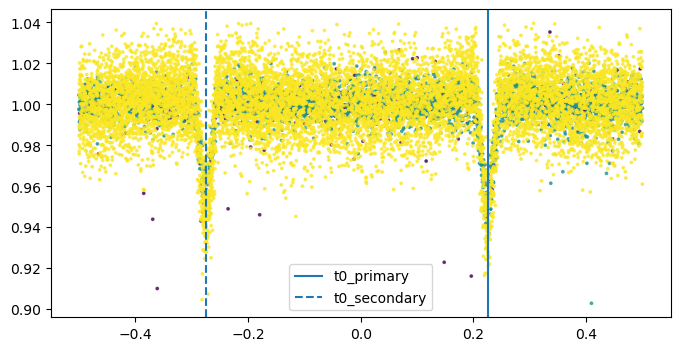

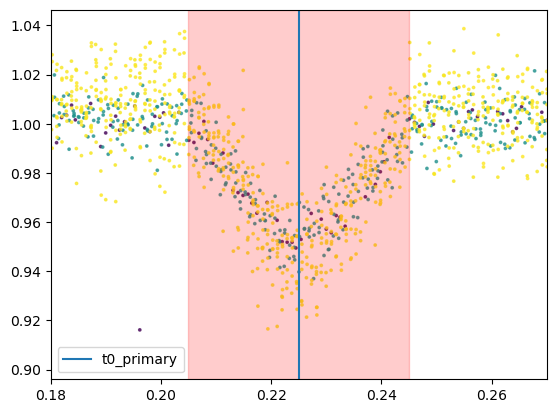

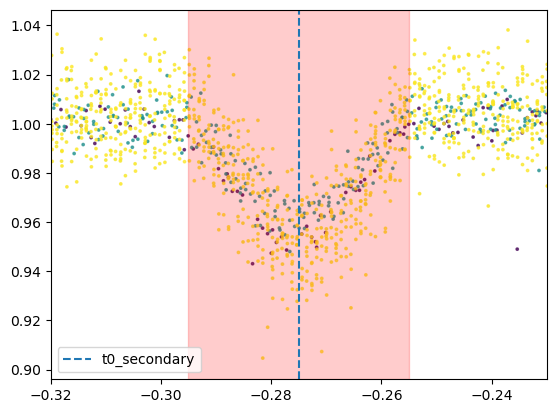

In [38]:
%matplotlib inline
# %matplotlib widget

# define the orbital period and the t0

# epoch=epoch=3071.47, duration_hr=2.5, period=1.30092, label="EB2all",
# MCMC on df_primary: p: 2.6018314437987264, std_p: 2.0442595399795084e-06 ; t0: 1598.832496191893, std_t0: 0.0008058707062775774

# FILL-IN THE eclipse epoch / period,
period = 2.60184  # visual, 1.30092 * 2
period = 2.60183  # MCMC results has no 6 digit precision (error: 2e-6), but I need it to visually get a good enough period

t0_primary = 3071.47  #  visual
t0_primary = 1598.832  # MCMC

t0_secondary = t0_primary + period / 2

duration_hr_primary = 2.5
duration_hr_secondary = 2.5

# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

t0_for_plotting = 0  # keep 0 for plotting purposes
if t0_secondary is not None:
    t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    # plt.ylim(0.975, 1.005);
    plt.show()

### Compare folded plots across sectors

In [ ]:
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_primary)
        lc_f = lc_f.truncate(-duration_hr_primary * 2 / 24, duration_hr_primary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0:
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around primary eclipses");
plt.tight_layout();

# ---
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_secondary)
        lc_f = lc_f.truncate(-duration_hr_secondary * 2 / 24, duration_hr_secondary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0:
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around secondary eclipses");
plt.tight_layout();

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [131]:
data["flux_original"] = data.flux  # save the original flux 

In [132]:
# show data to visualize what's changed in each step below
data

time      flux       err     phase  flux_original
0      1596.807343  0.983134  0.004864  0.446834       0.983134
1      1596.828177  1.016687  0.004864  0.454841       1.016687
2      1596.849011  1.001035  0.004864  0.462848       1.001035
3      1596.869845  1.001064  0.004864  0.470856       1.001064
4      1596.890679  0.999851  0.004864  0.478863       0.999851
...            ...       ...       ...       ...            ...
14088  3094.487711  0.975013  0.015101  0.072592       0.975013
14089  3094.490026  1.001165  0.015101  0.073482       1.001165
14090  3094.492341  0.981806  0.015101  0.074372       0.981806
14091  3094.496971  0.995178  0.015101  0.076151       0.995178
14092  3094.499285  1.029777  0.015101  0.077041       1.029777

[14093 rows x 5 columns]

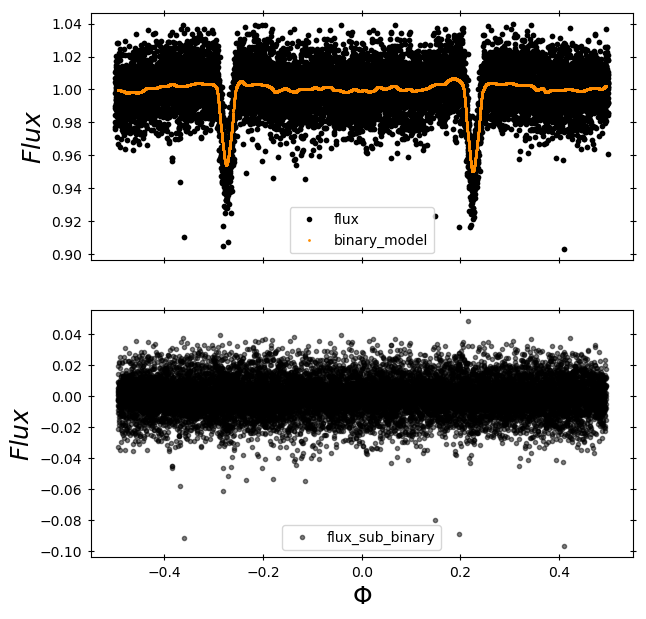

time      flux       err     phase  flux_original  \
0      1596.807343  0.983134  0.004864  0.446834       0.983134   
1      1596.828177  1.016687  0.004864  0.454841       1.016687   
2      1596.849011  1.001035  0.004864  0.462848       1.001035   
3      1596.869845  1.001064  0.004864  0.470856       1.001064   
4      1596.890679  0.999851  0.004864  0.478863       0.999851   
...            ...       ...       ...       ...            ...   
14088  3094.487711  0.975013  0.015101  0.072592       0.975013   
14089  3094.490026  1.001165  0.015101  0.073482       1.001165   
14090  3094.492341  0.981806  0.015101  0.074372       0.981806   
14091  3094.496971  0.995178  0.015101  0.076151       0.995178   
14092  3094.499285  1.029777  0.015101  0.077041       1.029777   

       flux_sub_binary  binary_model  
0            -0.015848      0.998982  
1             0.016820      0.999867  
2             0.000490      1.000545  
3             0.000173      1.000891  
4            -0.000893      1.000744  
...                ...           ...  
14088        -0.025696      1.000709  
14089         0.000659      1.000507  
14090        -0.018538      1.000344  
14091        -0.004956      1.000134  
14092         0.029739      1.000038  

[14093 rows x 7 columns]

In [133]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

10 13953 10
reached the end
10 13665 10
reached the end
10 13597 10
reached the end
10 13579 10
reached the end
10 13575 10
reached the end


time      flux       err     phase  flux_original  \
0      1596.807343  0.983134  0.004864  0.446834       0.983134   
1      1596.828177  1.016687  0.004864  0.454841       1.016687   
2      1596.849011  1.001035  0.004864  0.462848       1.001035   
3      1596.869845  1.001064  0.004864  0.470856       1.001064   
4      1596.890679  0.999851  0.004864  0.478863       0.999851   
...            ...       ...       ...       ...            ...   
14088  3094.487711  0.975013  0.015101  0.072592       0.975013   
14089  3094.490026  1.001165  0.015101  0.073482       1.001165   
14090  3094.492341  0.981806  0.015101  0.074372       0.981806   
14091  3094.496971  0.995178  0.015101  0.076151       0.995178   
14092  3094.499285  1.029777  0.015101  0.077041       1.029777   

       flux_sub_binary  binary_model  flux_detrended  
0            -0.015848      0.998982        0.983108  
1             0.016820      0.999867        1.016658  
2             0.000490      1.000545        1.001053  
3             0.000173      1.000891        1.001079  
4            -0.000893      1.000744        0.999871  
...                ...           ...             ...  
14088        -0.025696      1.000709        0.977428  
14089         0.000659      1.000507        1.003930  
14090        -0.018538      1.000344        0.984921  
14091        -0.004956      1.000134        0.998643  
14092         0.029739      1.000038             NaN  

[14093 rows x 8 columns]

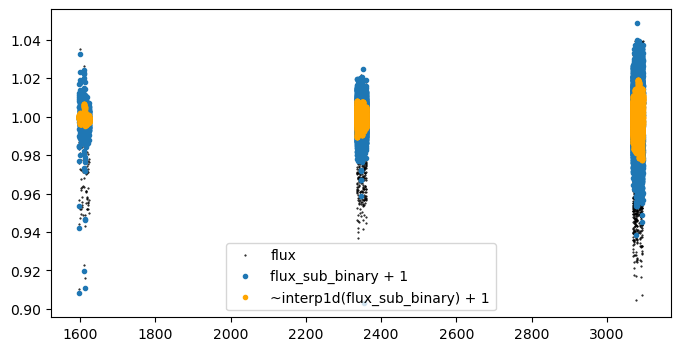

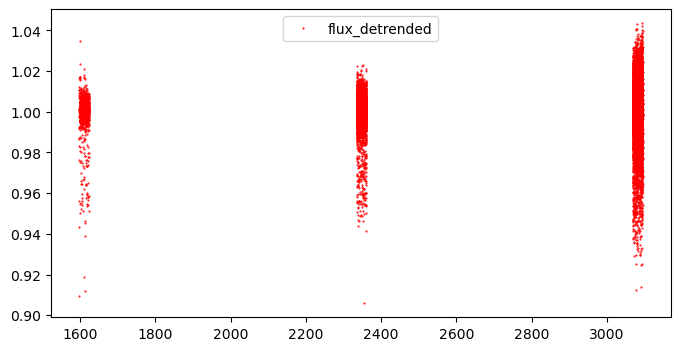

In [143]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = duration_hr_primary / 24, plot = True)
data

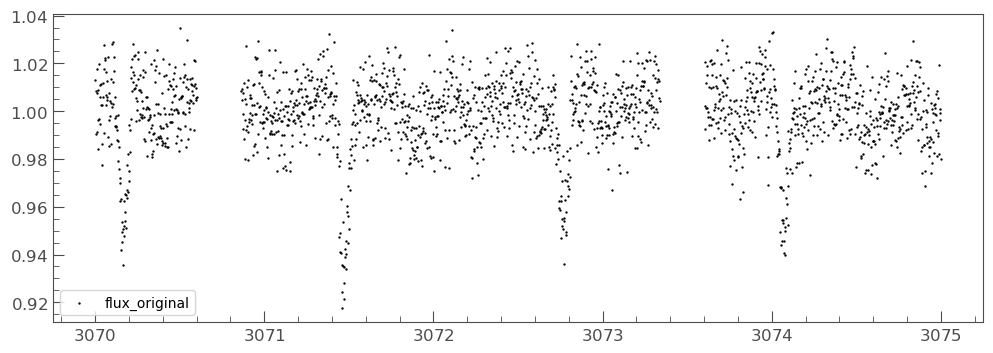

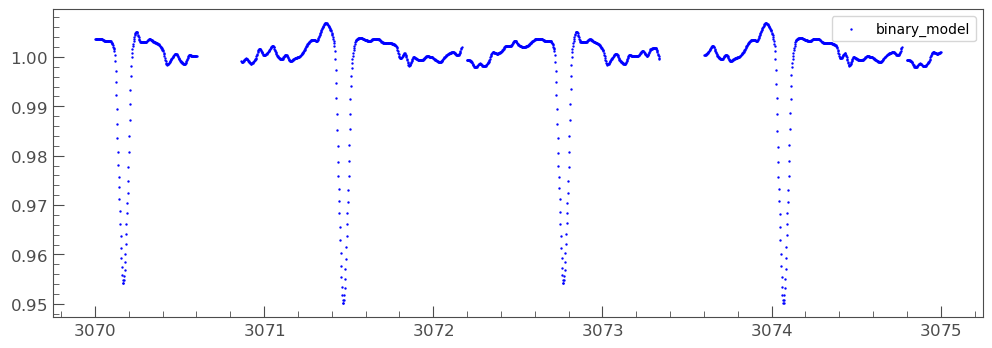

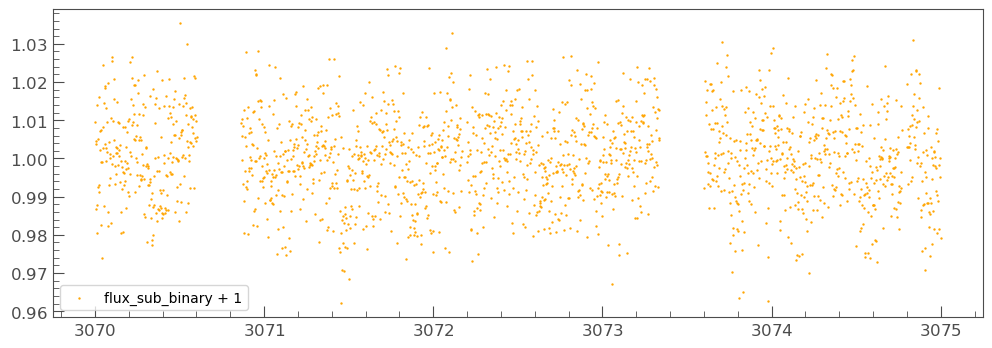

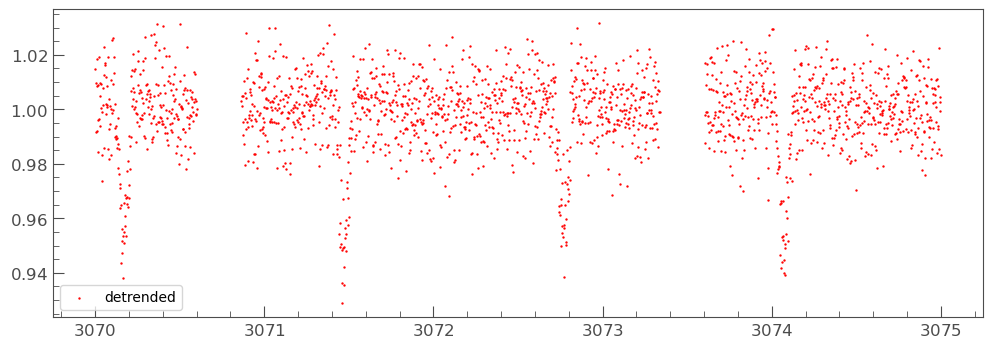

In [146]:
data_subset = data[(3070 < data.time) & (data.time < 3075) ]

ax = tplt.lk_ax(figsize=(12, 4))
ax.scatter(data_subset.time, data_subset.flux_original, s=0.5, c="black", label="flux_original"); ax.legend();

ax = tplt.lk_ax(figsize=(12, 4))
ax.scatter(data_subset.time, data_subset.binary_model, s=0.5, c="blue", label="binary_model"); ax.legend();

ax = tplt.lk_ax(figsize=(12, 4))
ax.scatter(data_subset.time, data_subset.flux_sub_binary + 1, s=0.5, c="orange", label="flux_sub_binary + 1"); ax.legend();

ax = tplt.lk_ax(figsize=(12, 4))
ax.scatter(data_subset.time, data_subset.flux_detrended, s=0.5, c="red", label="detrended"); ax.legend();


In [ ]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period 
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period 
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    # plt.ylim(0.975, 1.005);
    plt.show()

In [149]:
# Uncomment to use the detrended flux
#
print("Use deterended flux")
data.flux = data.flux_detrended

Use deterended flux


### Now that the data is ready we can start 

- generally the clipped LC window is ***smaller*** than the eclipse duration, to avoid the complication of fitting ingress/egress.

In [150]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# the eclipse duration is short, increase window width so that I have more data points per cycle to model, 
# but I can't afford to make ti too large as there is noticeable oscillation outside of eclipses as well
window_width_p = 1.3 * duration_hr_primary / 24 / period   
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 1.3 * duration_hr_secondary / 24 / period
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)

    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V)
# t0 in normalixed phase
start_vals = [1.0025, -0.0507, midpoint_p, 0.0100, 1.12]
start_vals_s = [1.0, -0.05, midpoint_s, 0.009, 1.1]


# -- -- -- -- -- -- -- -- --
# etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess_interactive(data_primary, ph_binned, flux_binned, err_binned, "midpoint_p", *start_vals)
if t0_secondary is not None:
    # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)
    etv_functions.plot_initial_guess_interactive(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, "midpoint_s", *start_vals_s)

print("Start params for  fitting period with MCMC on df_primary:")
print(f"[{start_vals[0]}, {start_vals[1]}, {t0_primary}, {start_vals[3]}, {start_vals[4]}, {period}],");

Primary:   1598.832 0.22500000000001863
window_width_p (phase): 0.052046700463391785
Secondary: 1597.531085 -0.2749999999999935
window_width_s (phase): 0.052046700463391785


Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Start params for  fitting period with MCMC on df_primary:
[1.0025, -0.0507, 1598.832, 0.01, 1.12, 2.60183],


In [ ]:
if False:
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 3000/3000 [03:06<00:00, 16.05it/s]


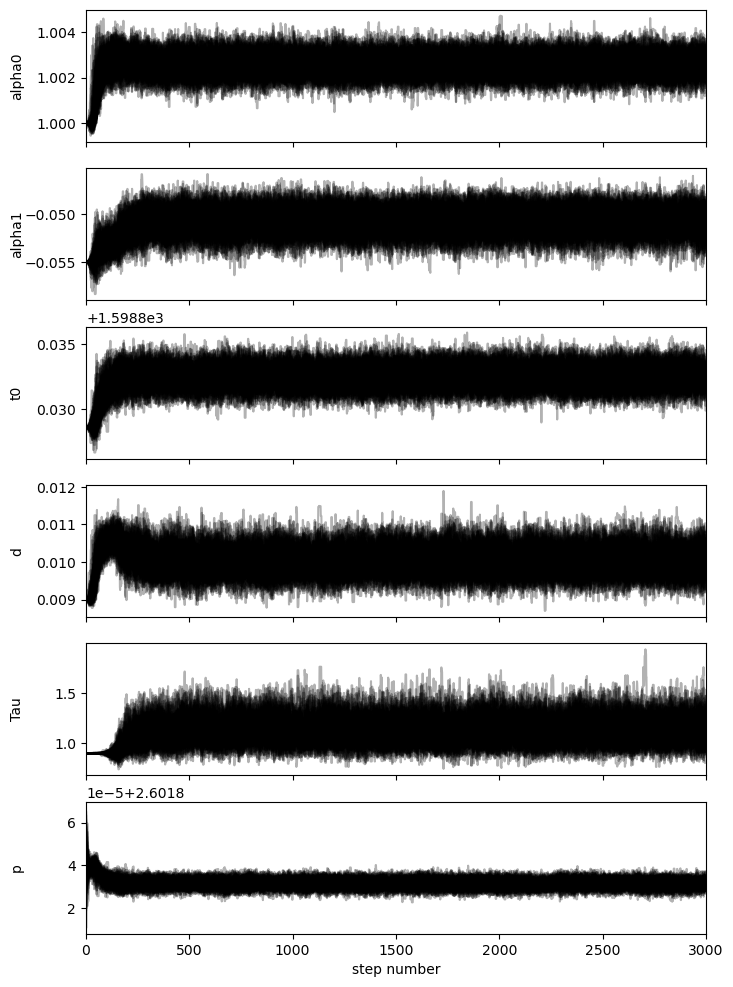

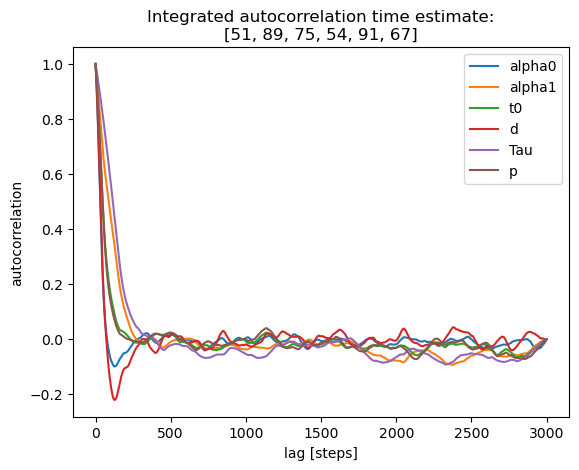

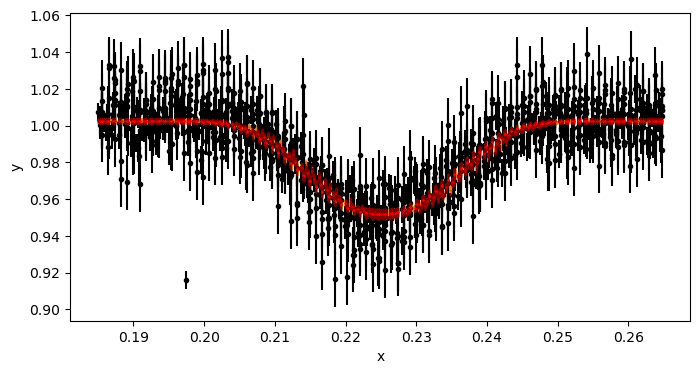

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0025809056216852, -0.05071110691579698, 1598.832496191893, 0.010028526018034185, 1.1233951519176468, 2.6018314437987264
std_p: 2.0442595399795084e-06 ; std_t0: 0.0008058707062775774


In [34]:
# use MCMC to refine the period

use_mcmc_to_fit_period = True


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp

    etv_functions.enable_info_log_for_jupyter()

    # MCMC result
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        [1.0, -0.055, 1598.8285599999997, 0.009, 0.9, 2.60184],
        # nruns=20, discard=1, # for a sanity test,  to ensure the initial guess is not way off.
        nruns=3000, discard=1000,
        autocorr_time_kwargs=dict(tol=20),  # the emcee defaults tol=50 seems to be too strict for our use case, tol of ~10 - 20 seems to be sufficient
        pool=-2,
        plot_chains=True,
        plot_autocorrelation=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"], "; std_t0:", fit_params_p_stats['std_t0'])
    !$NOTIFY_CMD "Fitting period done."

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 3000/3000 [03:22<00:00, 14.80it/s]


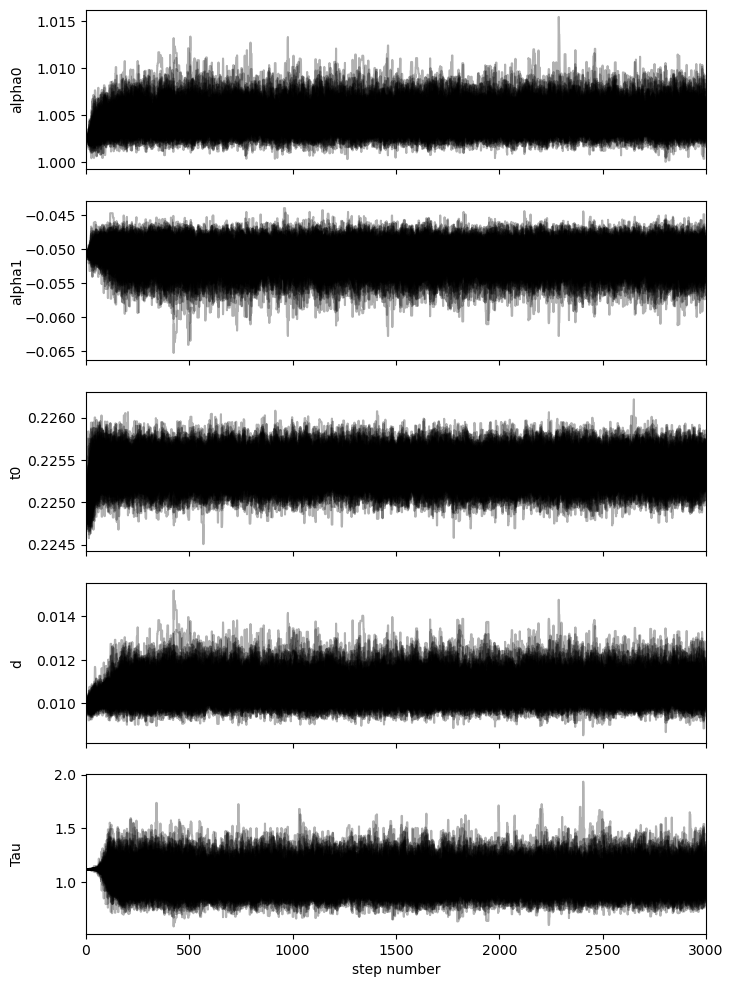

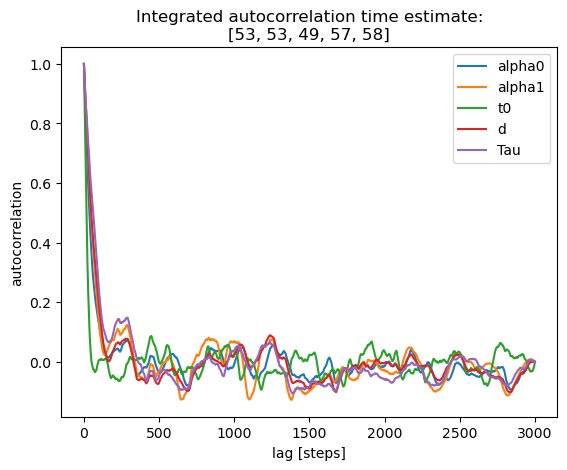

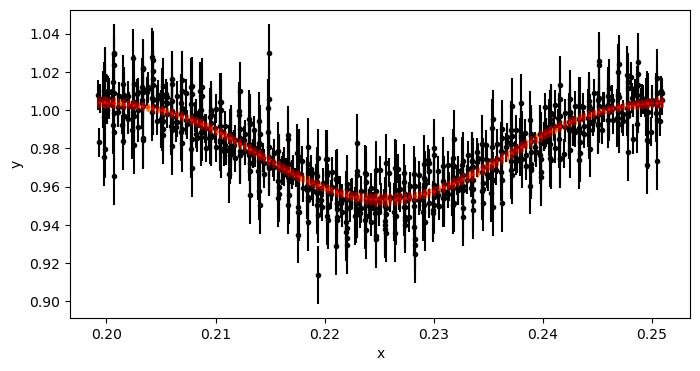

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 3000/3000 [03:19<00:00, 15.00it/s]


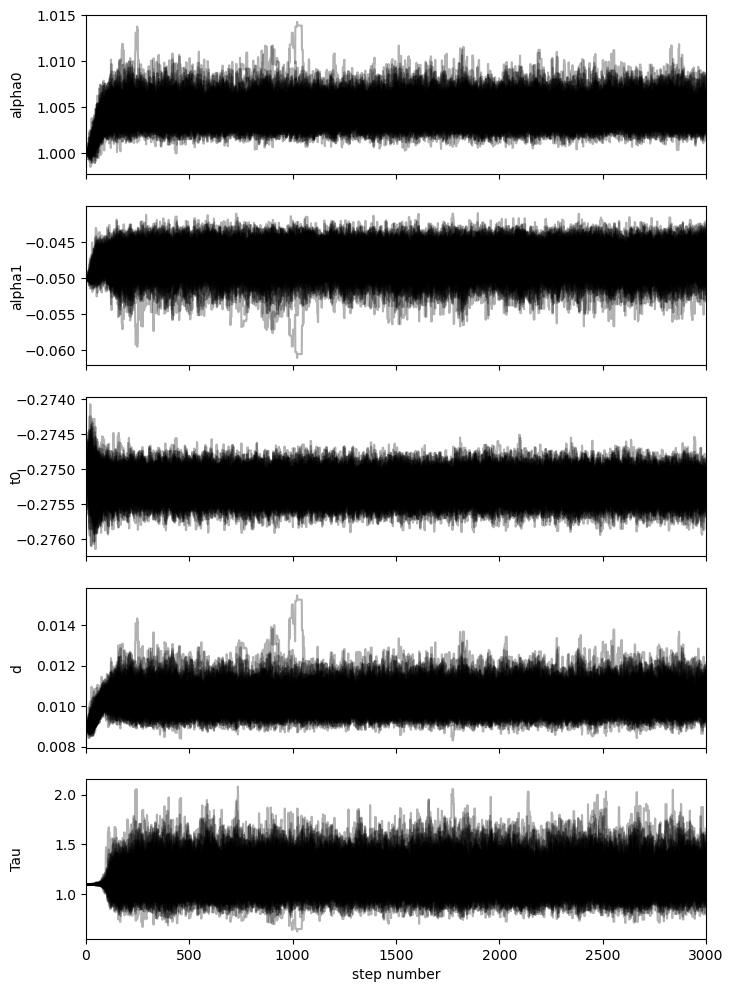

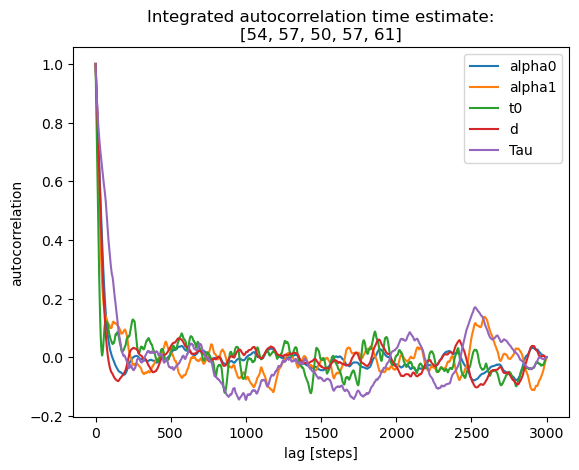

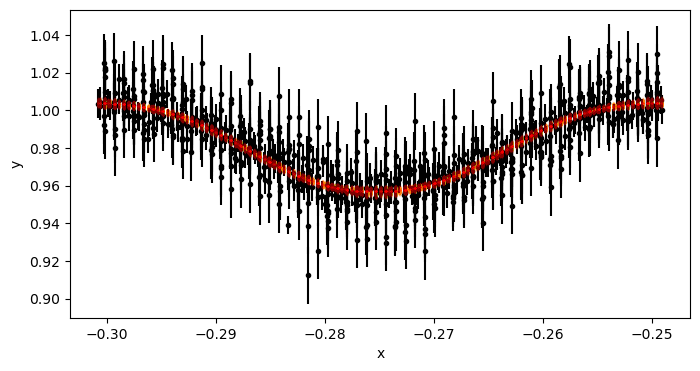

In [151]:
# run the initial model fit using MCMC for the primary and secondary eclipses
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()
    
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, fit_params_stats = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns=3000, discard=600, autocorr_time_kwargs=dict(tol=20), pool=-2, plot_chains=True,  plot_autocorrelation=True, plot=True, also_return_stats=True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, fit_params_s_stats = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns=3000, discard=600, autocorr_time_kwargs=dict(tol=20), pool=-2, plot_chains=True,  plot_autocorrelation=True, plot=True, also_return_stats=True)
    !$NOTIFY_CMD "Initial fit done"

In [ ]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # initial fit params from TESS data
    # raw data
    # mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.004440179882986, -0.05295206191077084, 0.2253713674387876, 0.010607001423855768, 1.0361628533367866
    # mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0050004035522015, -0.0492659672122193, -0.27511084668377395, 0.010337248010024853, 1.1528444777740705

    # detrened (use data.flux_detrended)
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0045899118728694, -0.05111228013232335, 0.2253943794352858, 0.010672862470805485, 1.0290385198861187
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0043930484078063, -0.04736981543012348, -0.2752532091456922, 0.010312115179084862, 1.1653308855999742
    
    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])

In [152]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0045899118728694, -0.05111228013232335, 0.2253943794352858, 0.010672862470805485, 1.0290385198861187
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0043930484078063, -0.04736981543012348, -0.2752532091456922, 0.010312115179084862, 1.1653308855999742


573

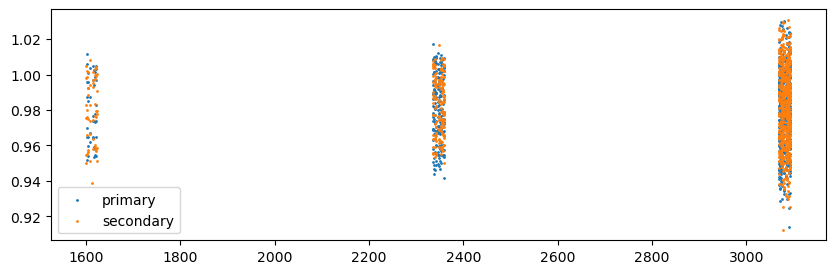

In [153]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1598.832 2.60183 1598.832


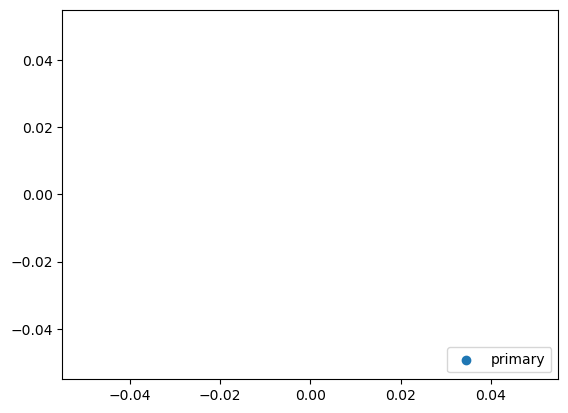

1598.832 2.60183 1601.4338300000002


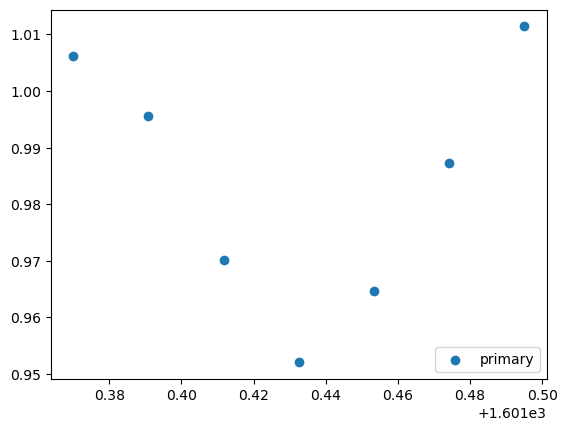

1598.832 2.60183 1604.03566


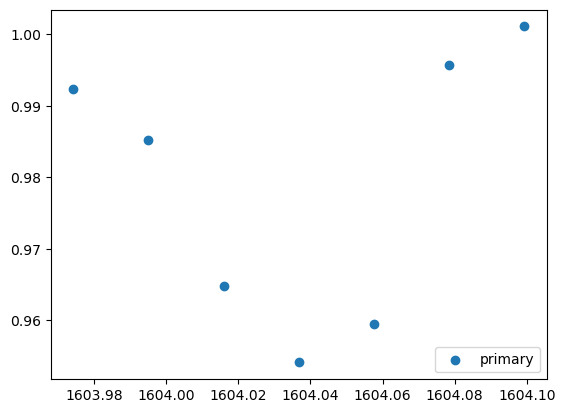

1598.832 2.60183 3081.8751


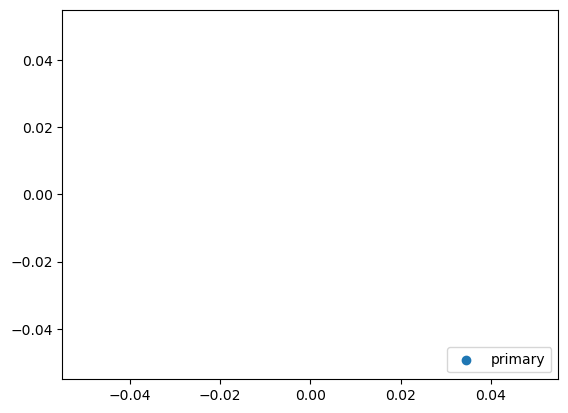

1598.832 2.60183 3084.4769300000003


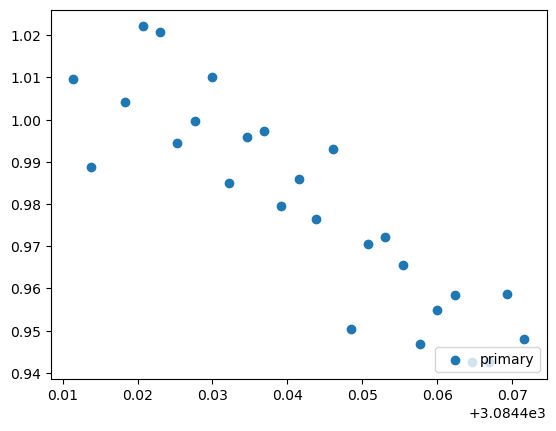

1598.832 2.60183 3087.0787600000003


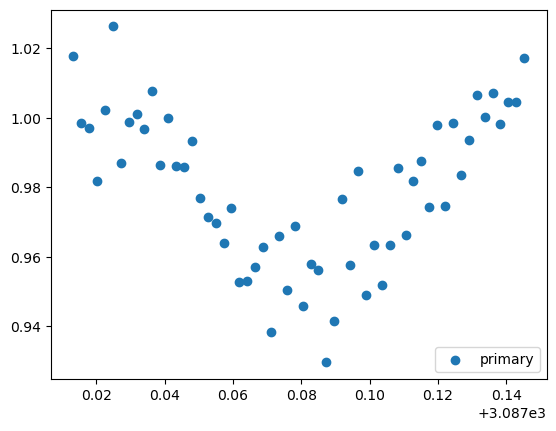

1597.531085 2.60183 1597.531085


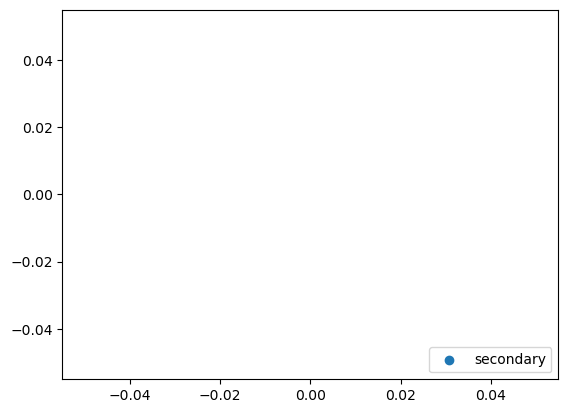

1597.531085 2.60183 1600.1329150000001


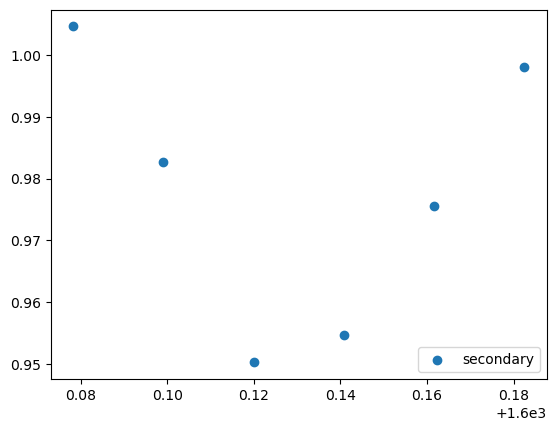

1597.531085 2.60183 1602.734745


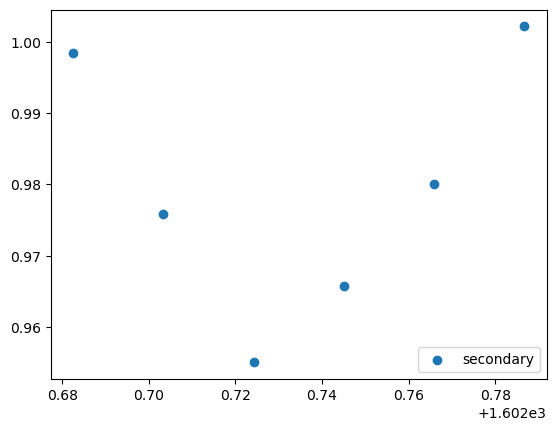

1597.531085 2.60183 3080.5741850000004


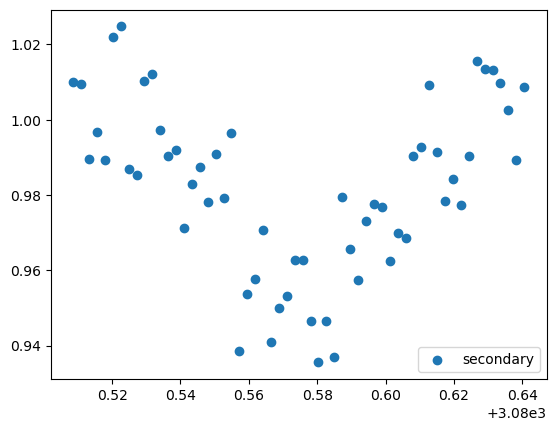

1597.531085 2.60183 3083.176015


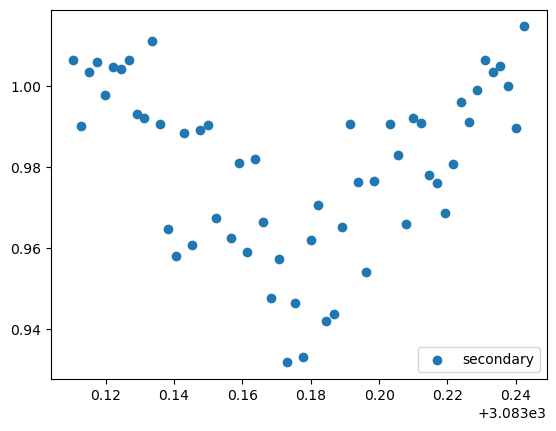

1597.531085 2.60183 3085.777845


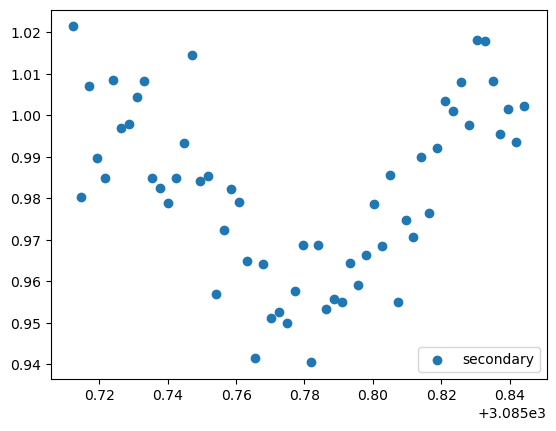

In [155]:
tr_index = range(0,n_transits)

for i in np.concatenate( (tr_index[0:3], tr_index[-3:]) ): 
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux)
    yerr = np.array(data_primary.err)

    print (t0_primary, period, transit_time)

    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period)))

    x = np.array(x[mask])
    y = np.array(y[mask])
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()


if t0_secondary is not None:
    for i in np.concatenate( (tr_index[0:3], tr_index[-3:]) ): 
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux)
        yerr = np.array(data_secondary.err)

        print (t0_secondary, period, transit_time)

        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period)))

        x = np.array(x[mask])
        y = np.array(y[mask])
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

### Fit individual eclipses

In [156]:
# Provide a warning if the expected number of data points per clipped LC is smaller than the default minimum `min_number_data` (20)
longest_cadence = np.max(sr.exptime)
est_number_data_primary   = int(window_width_p  * period * 24 / longest_cadence.to(u.hr).value)
print(f"Expected num of data points of a clipped LC in longest cadence ({longest_cadence}) for primary: {est_number_data_primary}")
if est_number_data_primary < 20:
    display(HTML("<span style='background-color: rgba(255, 0, 0, 0.7); padding-left: 1ch; padding-right: 1ch;'>WARN:</span> num of data points for a clipped LC (primary) < 20"))

if t0_secondary is not None:
    est_number_data_secondary = int(window_width_s  * period * 24 / longest_cadence.to(u.hr).value)
    print(f"Expected num of data points of a clipped LC in longest cadence ({longest_cadence}) for secondary:  {est_number_data_secondary}")
    if est_number_data_secondary < 20:
        display(HTML("<span style='background-color: rgba(255, 0, 0, 0.7); padding-left: 1ch; padding-right: 1ch;'>WARN:</span> num of data points for a clipped LC (secondary) < 20"))

Expected num of data points of a clipped LC in longest cadence (1800.0 s) for primary: 6


Expected num of data points of a clipped LC in longest cadence (1800.0 s) for secondary:  6


Fitting individual primary eclipses...
Creating new manifest file
1601.4338300000002 1.0045899118728694 -0.05111228013232335 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.24it/s]


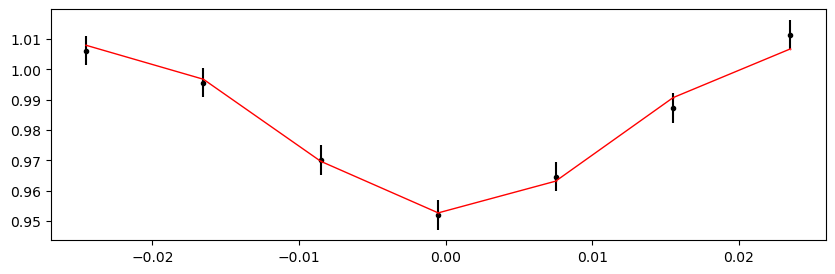

1604.03566 1.0045899118728694 -0.05111228013232335 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.58it/s]


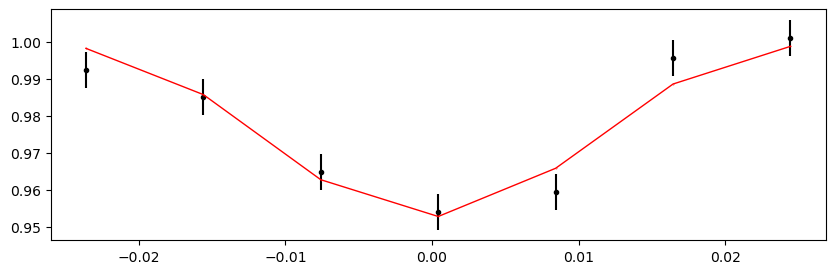

Time 1609.2393200000001 does not have enough data points: 4
1614.44298 1.0045899118728694 -0.05111228013232335 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.98it/s]


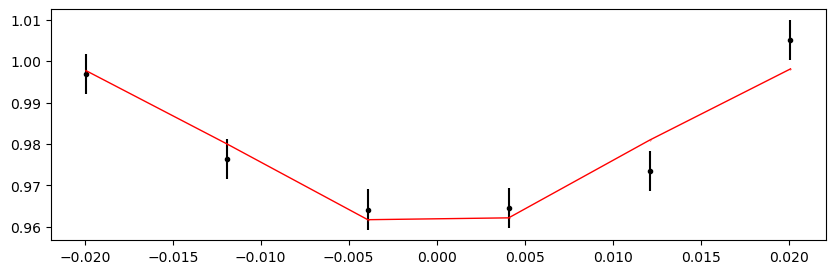

Time 1617.04481 does not have enough data points: 5
1619.6466400000002 1.0045899118728694 -0.05111228013232335 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.73it/s]


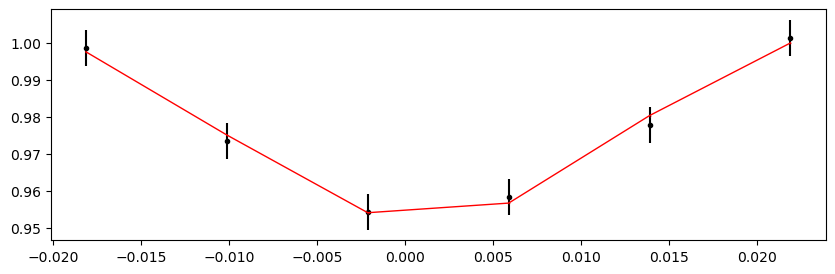

1622.24847 1.0045899118728694 -0.05111228013232335 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.78it/s]


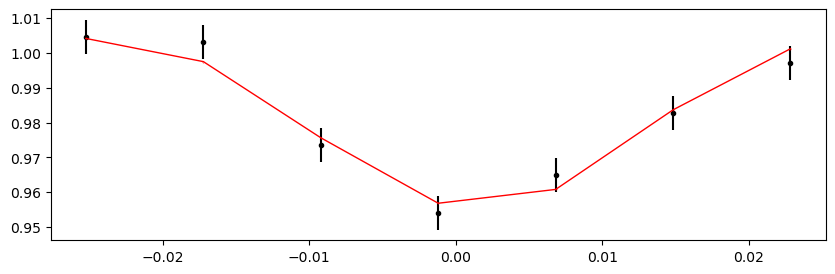

2335.14989 1.0045899118728694 -0.05111228013232335 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.20it/s]


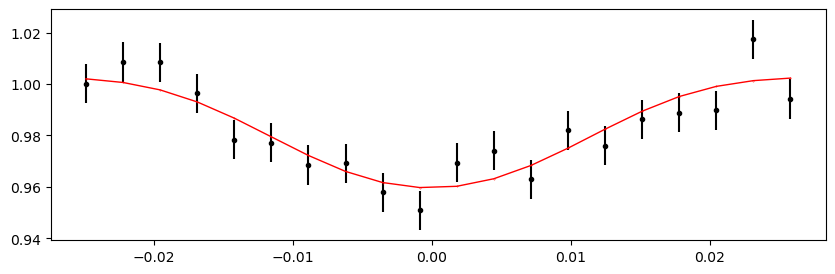

2337.75172 1.0045899118728694 -0.05111228013232335 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.79it/s]


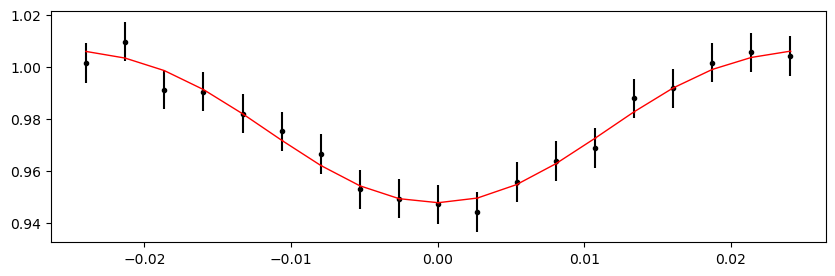

2340.3535500000003 1.0045899118728694 -0.05111228013232335 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.44it/s]


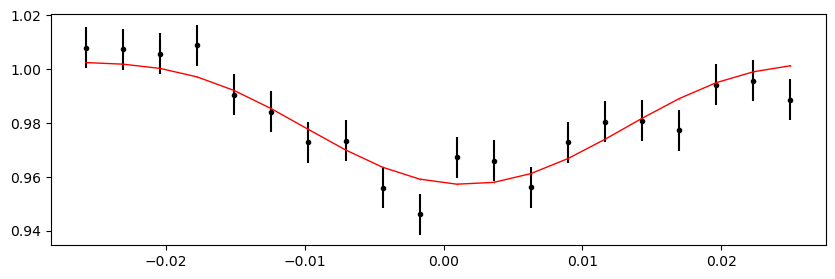

2342.9553800000003 1.0045899118728694 -0.05111228013232335 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.25it/s]


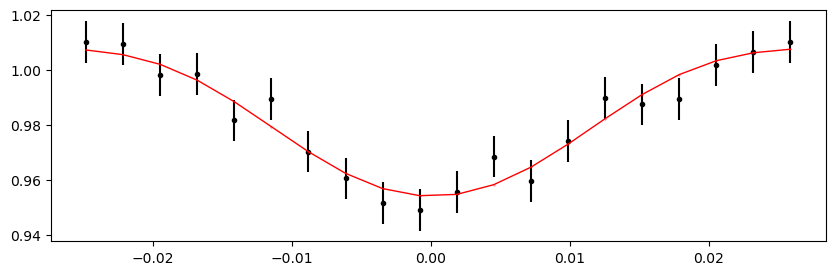

2345.55721 1.0045899118728694 -0.05111228013232335 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.10it/s]


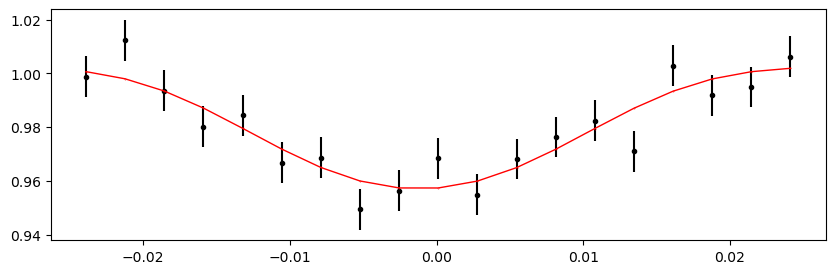

2348.15904 1.0045899118728694 -0.05111228013232335 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.75it/s]


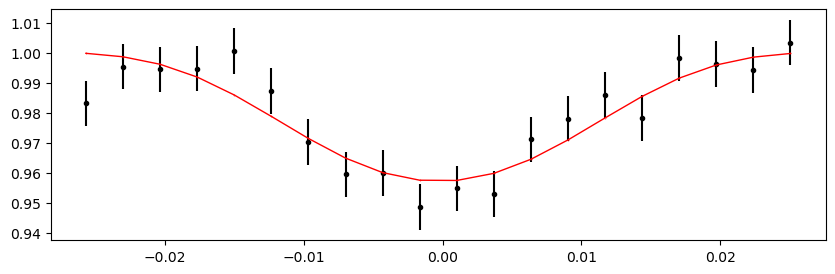

2350.76087 1.0045899118728694 -0.05111228013232335 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.21it/s]


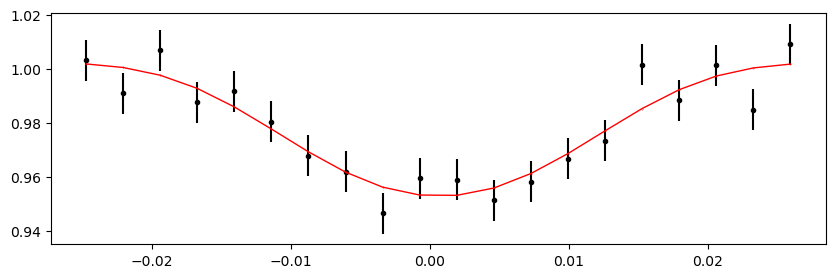

2353.3627 1.0045899118728694 -0.05111228013232335 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.32it/s]


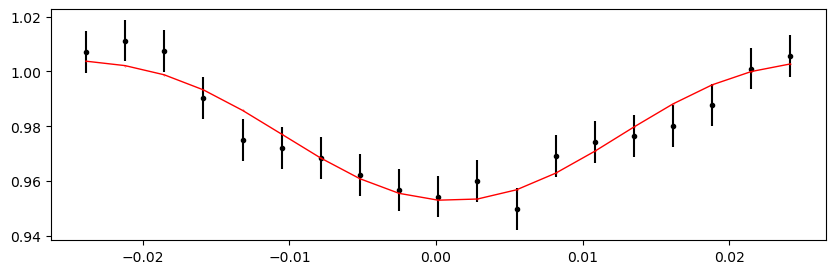

2355.96453 1.0045899118728694 -0.05111228013232335 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.55it/s]


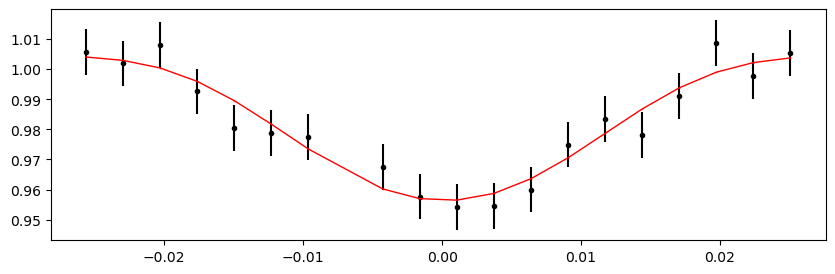

2358.5663600000003 1.0045899118728694 -0.05111228013232335 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.54it/s]


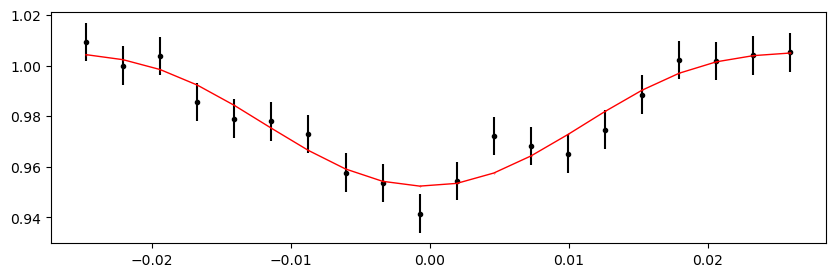

3068.8659500000003 1.0045899118728694 -0.05111228013232335 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.18it/s]


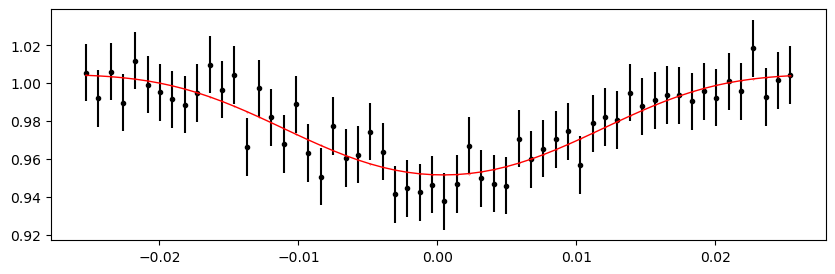

3071.46778 1.0045899118728694 -0.05111228013232335 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.53it/s]


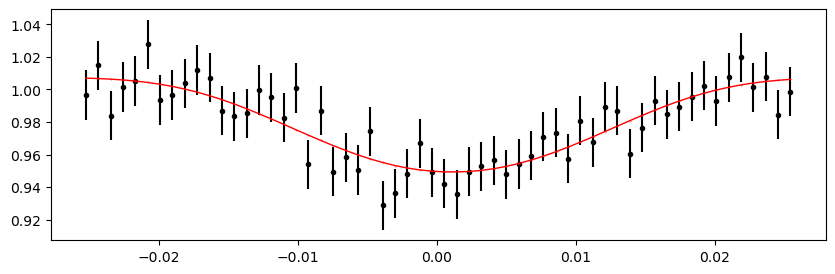

3074.0696100000005 1.0045899118728694 -0.05111228013232335 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.82it/s]


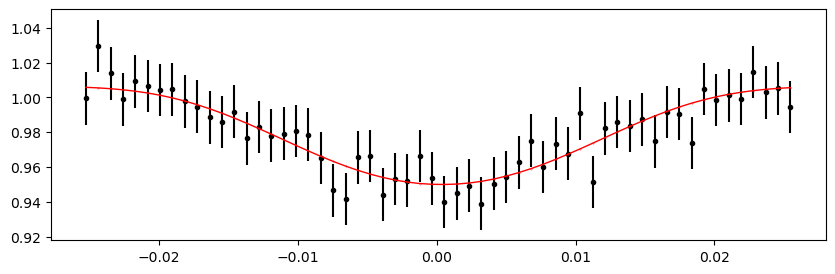

3076.67144 1.0045899118728694 -0.05111228013232335 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 344.55it/s]


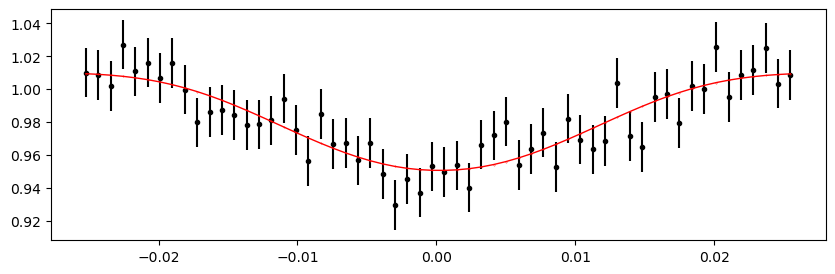

3079.27327 1.0045899118728694 -0.05111228013232335 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 354.66it/s]


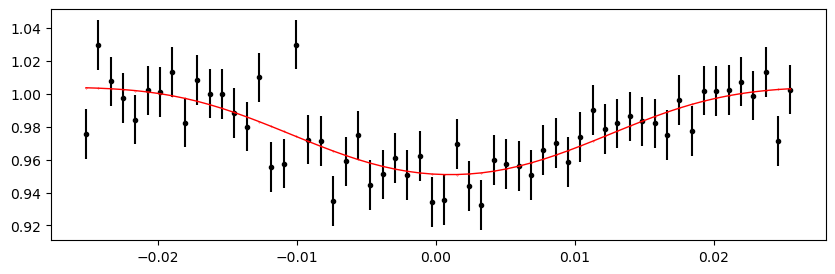

3084.4769300000003 1.0045899118728694 -0.05111228013232335 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.46it/s]


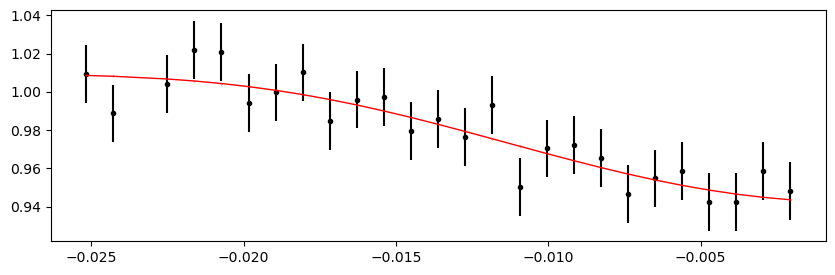

3087.0787600000003 1.0045899118728694 -0.05111228013232335 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 370.29it/s]


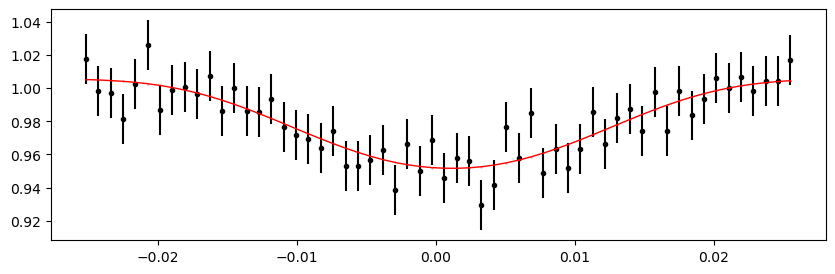

3089.68059 1.0045899118728694 -0.05111228013232335 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 365.34it/s]


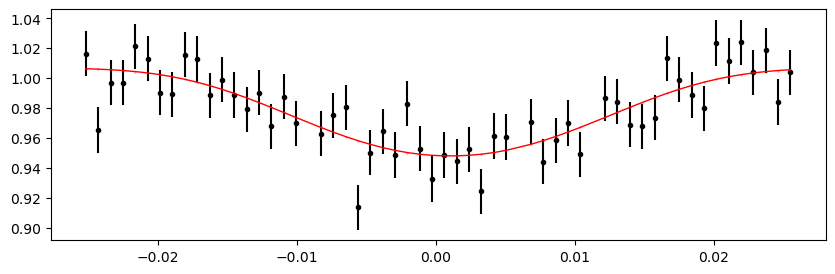

In [159]:
%matplotlib inline

# from importlib import reload
# reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=5,
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"


Fitting individual secondary eclipses...
Creating new manifest file
1600.1329150000001 1.0043930484078063 -0.04736981543012348 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.69it/s]


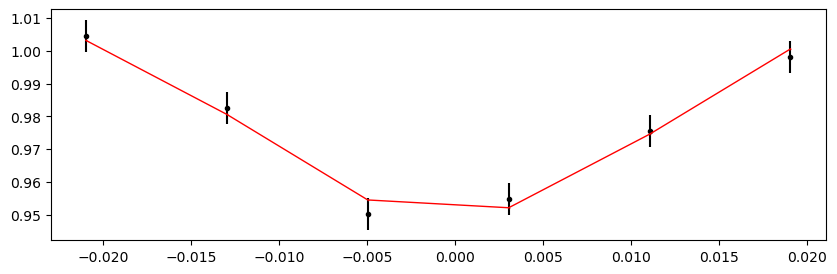

1602.734745 1.0043930484078063 -0.04736981543012348 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.44it/s]


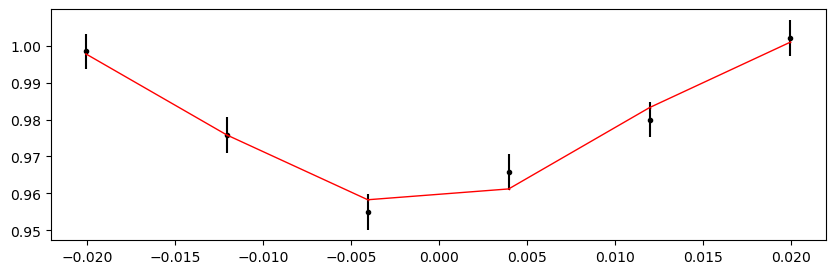

1605.336575 1.0043930484078063 -0.04736981543012348 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.03it/s]


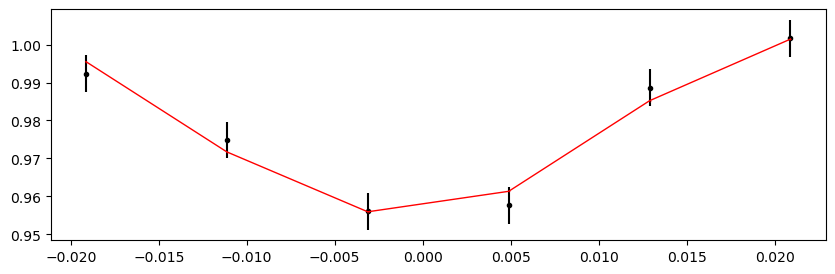

1607.938405 1.0043930484078063 -0.04736981543012348 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.92it/s]


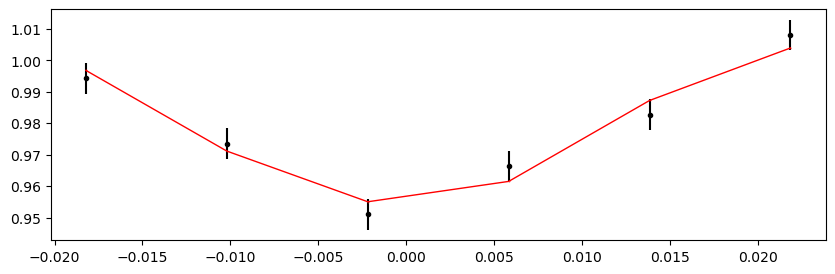

Time 1613.142065 does not have enough data points: 1
1615.743895 1.0043930484078063 -0.04736981543012348 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.11it/s]


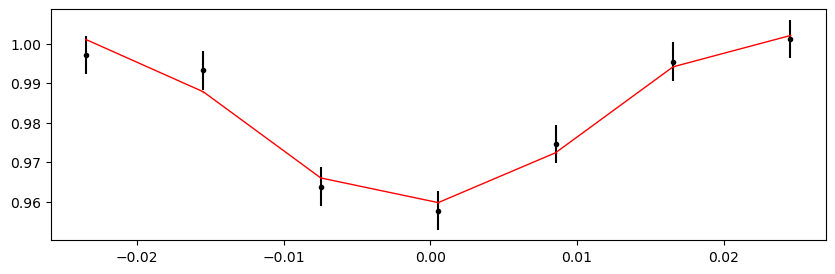

1618.3457250000001 1.0043930484078063 -0.04736981543012348 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.30it/s]


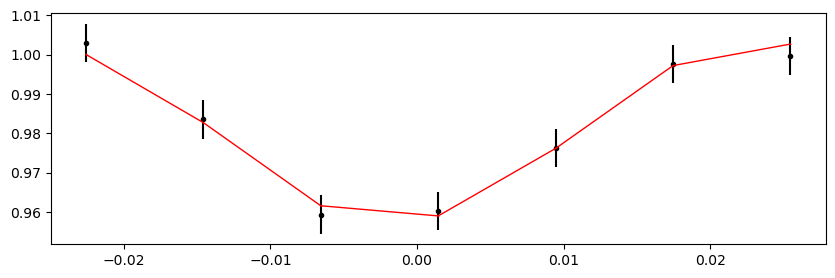

1620.947555 1.0043930484078063 -0.04736981543012348 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 377.28it/s]


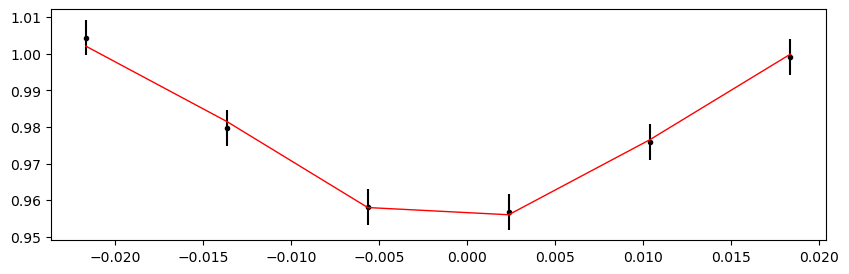

1623.549385 1.0043930484078063 -0.04736981543012348 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.10it/s]


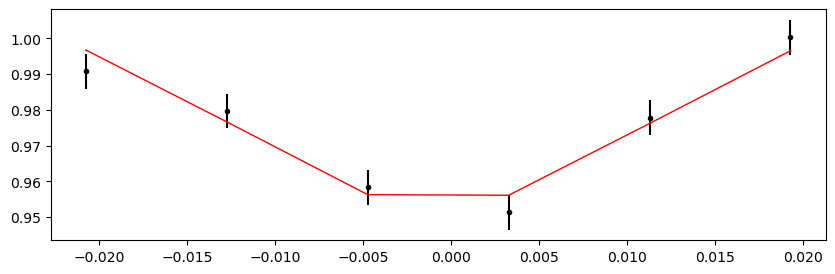

2336.450805 1.0043930484078063 -0.04736981543012348 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.58it/s]


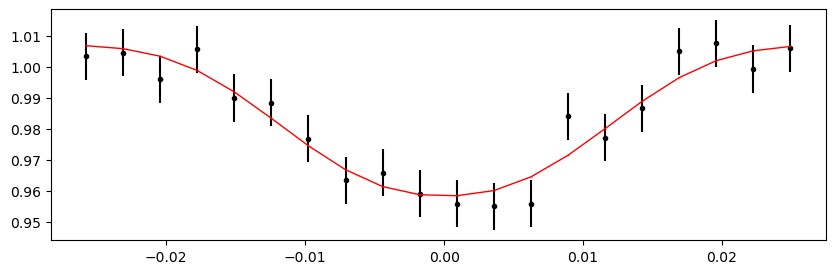

2339.052635 1.0043930484078063 -0.04736981543012348 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.85it/s]


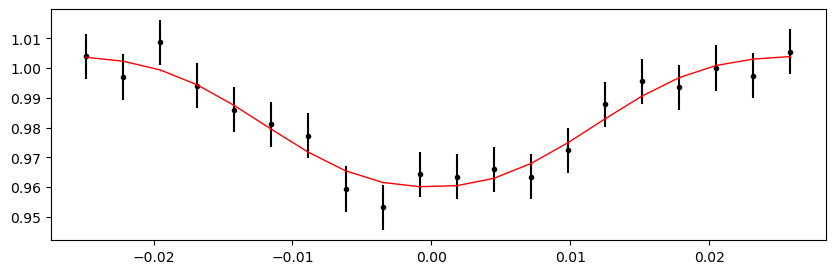

2341.654465 1.0043930484078063 -0.04736981543012348 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.67it/s]


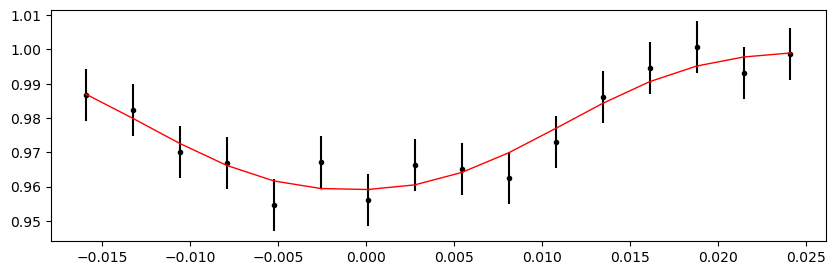

2349.4599550000003 1.0043930484078063 -0.04736981543012348 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 373.20it/s]


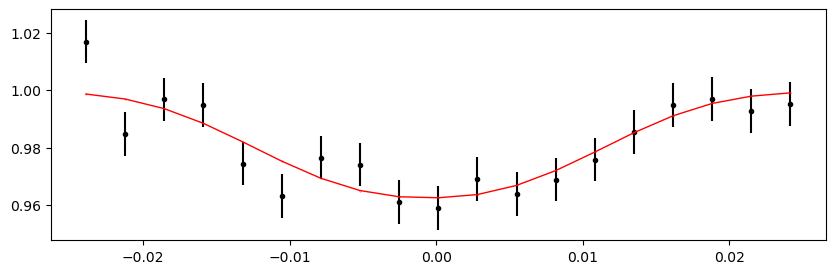

2352.061785 1.0043930484078063 -0.04736981543012348 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.18it/s]


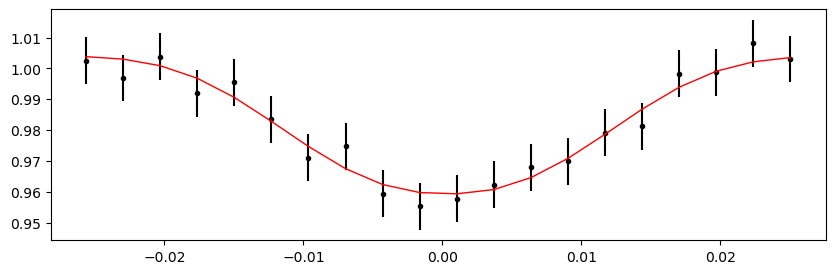

2354.663615 1.0043930484078063 -0.04736981543012348 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.84it/s]


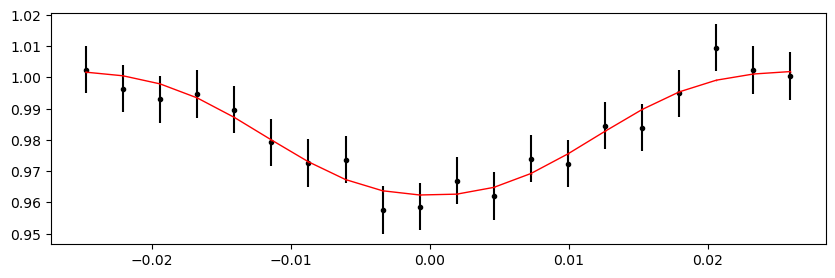

2357.265445 1.0043930484078063 -0.04736981543012348 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.76it/s]


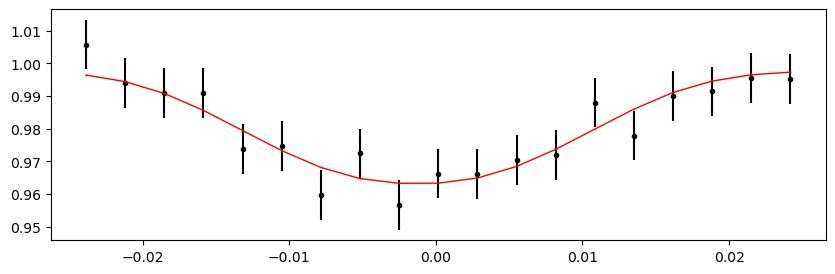

2359.867275 1.0043930484078063 -0.04736981543012348 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.38it/s]


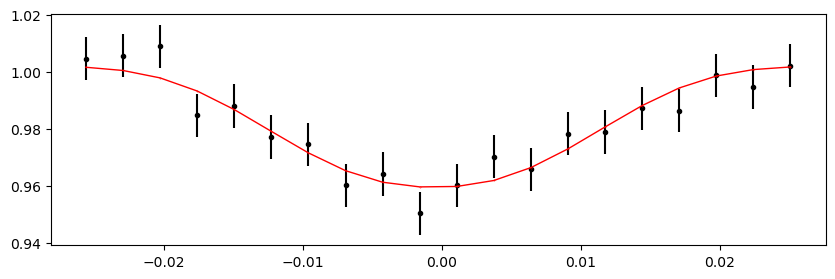

3070.166865 1.0043930484078063 -0.04736981543012348 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.74it/s]


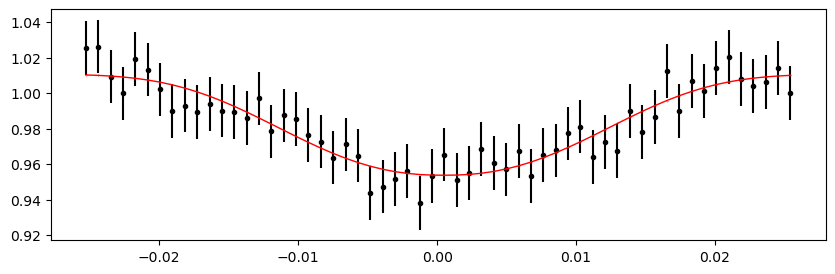

3072.768695 1.0043930484078063 -0.04736981543012348 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.00it/s]


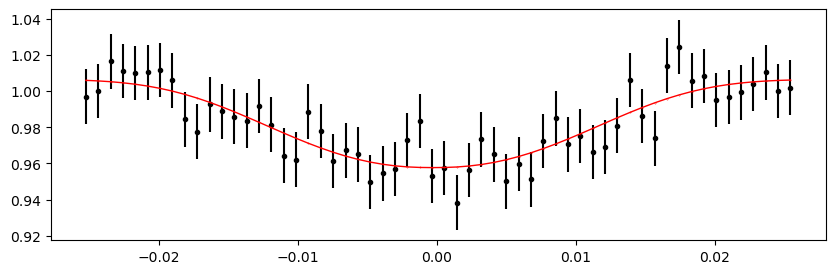

3075.3705250000003 1.0043930484078063 -0.04736981543012348 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.82it/s]


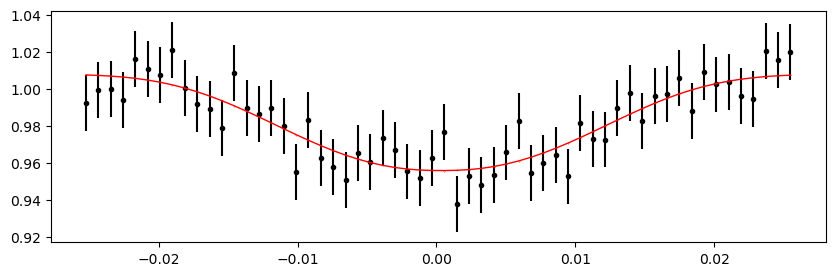

3077.972355 1.0043930484078063 -0.04736981543012348 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.93it/s]


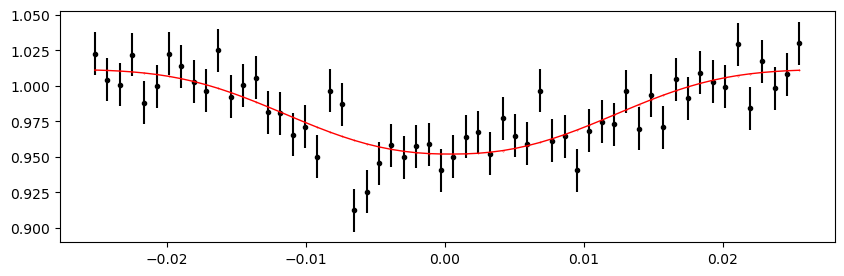

3080.5741850000004 1.0043930484078063 -0.04736981543012348 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.45it/s]


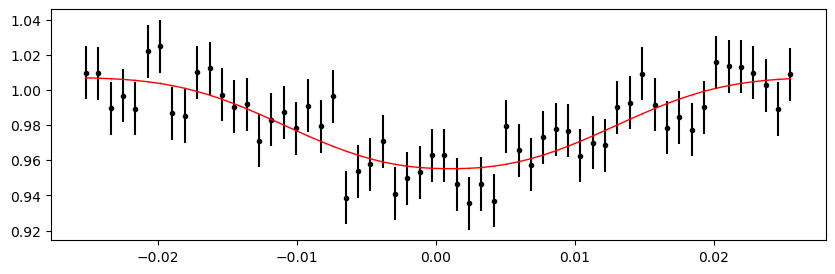

3083.176015 1.0043930484078063 -0.04736981543012348 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.13it/s]


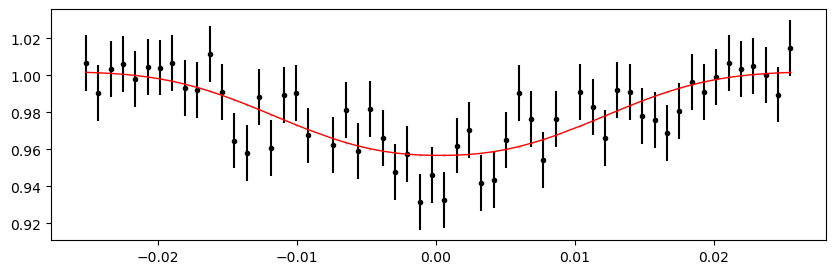

3085.777845 1.0043930484078063 -0.04736981543012348 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.77it/s]


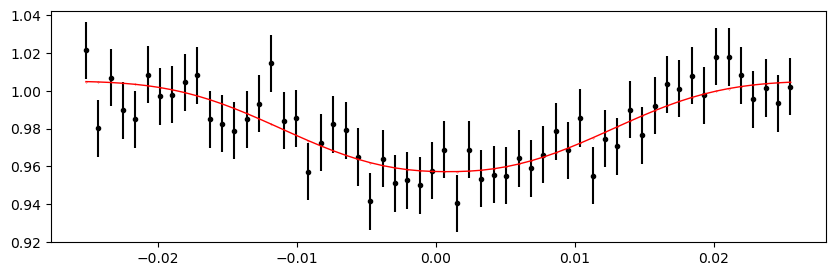

3088.379675 1.0043930484078063 -0.04736981543012348 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.26it/s]


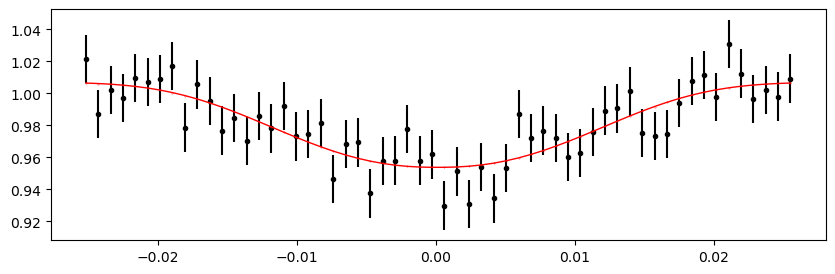

In [160]:
# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=5,
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

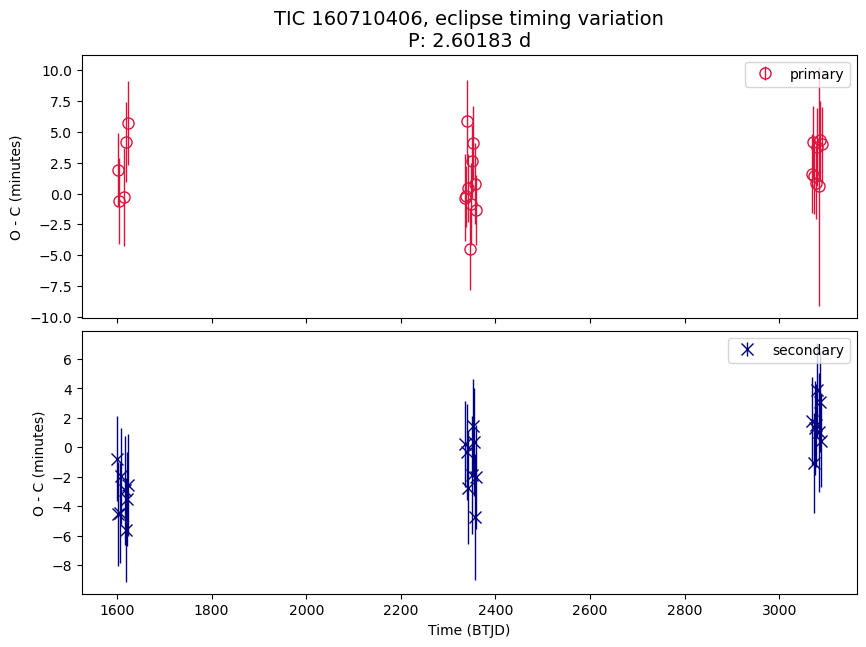

In [161]:
%matplotlib inline
# %matplotlib widget


title_suffix = "eclipse timing variation"

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary_all = in_df_primary  # in case filtering is helpful

# in_df_primary = in_df_primary[in_df_primary.std_mins < 10]  # filter out outliers in error
# print(f"Note: {len(in_df_primary_all) - len(in_df_primary)} data points in df_primary filtered out due to huge O-C error.")

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary_all = in_df_secondary  # in case filtering is helpful

    # in_df_secondary = in_df_secondary[in_df_secondary.std_mins < 10]  # filter out outliers in error
    # print(f"Note: {len(in_df_secondary_all) - len(in_df_secondary)} data points in in_df_secondary filtered out due to huge O-C error.")

    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, {title_suffix}\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

#### ETV results without detrend

The ETV results without detrend below is not much different from the results based on detrended lightcurve above

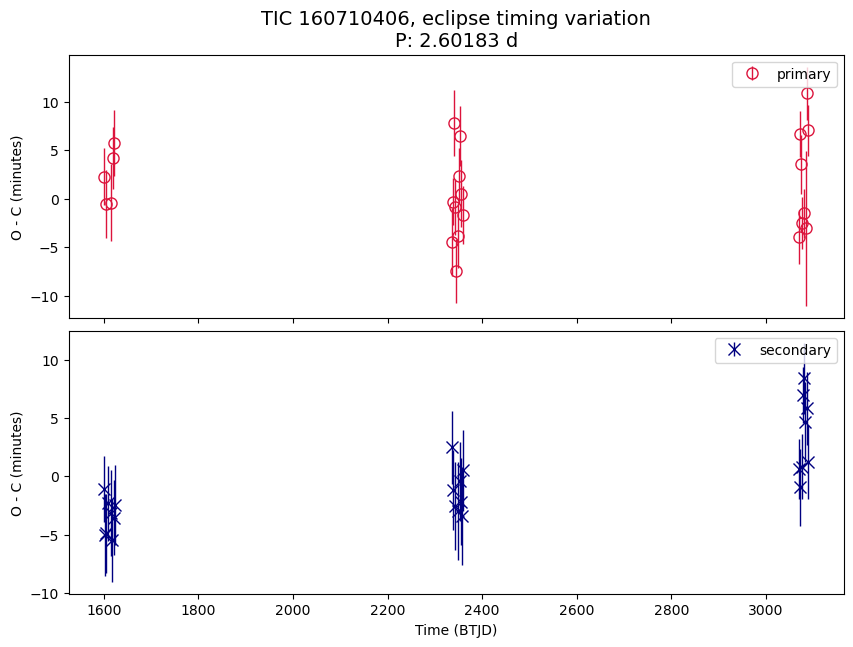

In [ ]:
# # to help to filter out valeus with huge error
# ax = in_df_primary_all.std_mins.hist(bins=100)
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.show()

# ax = in_df_secondary_all.std_mins.hist(bins=100)
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.show()

### O-C Plot, Zoom In

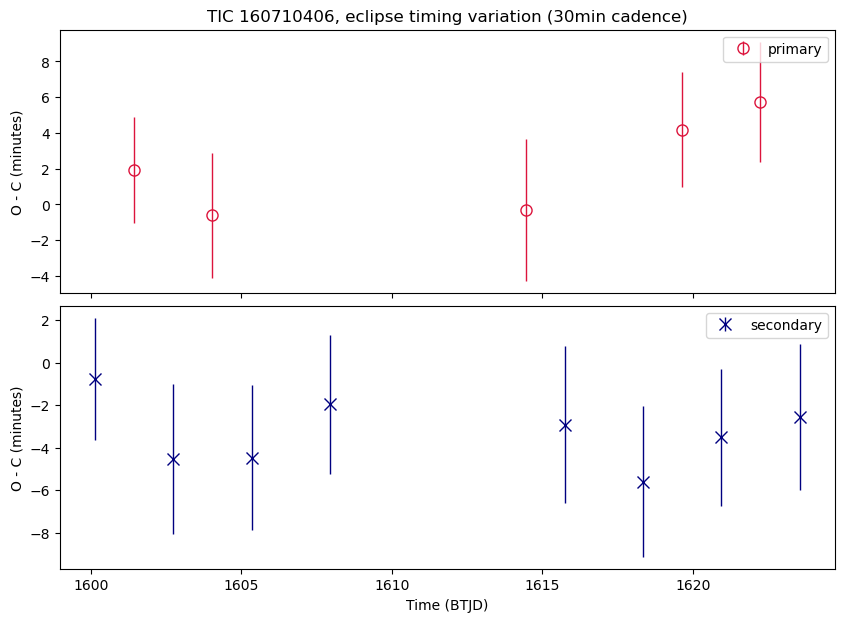

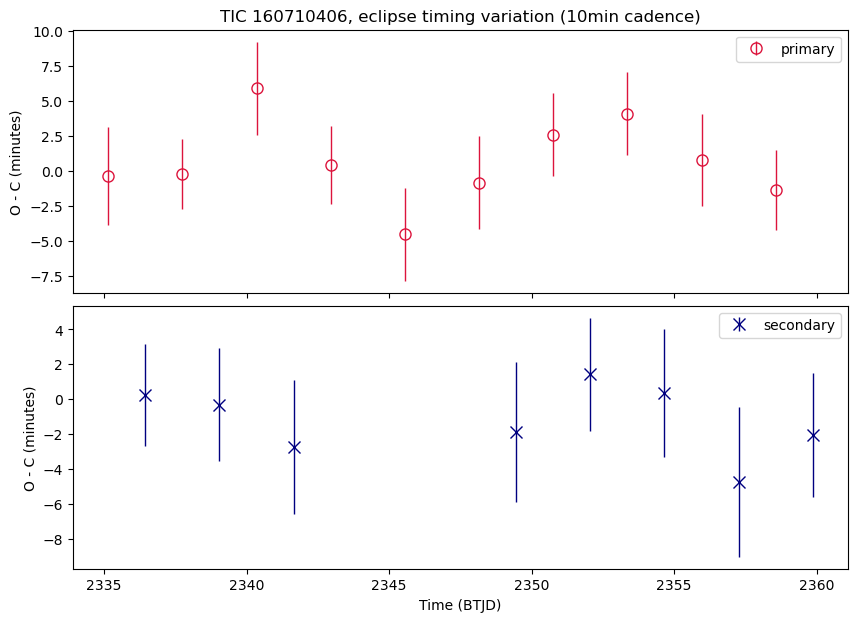

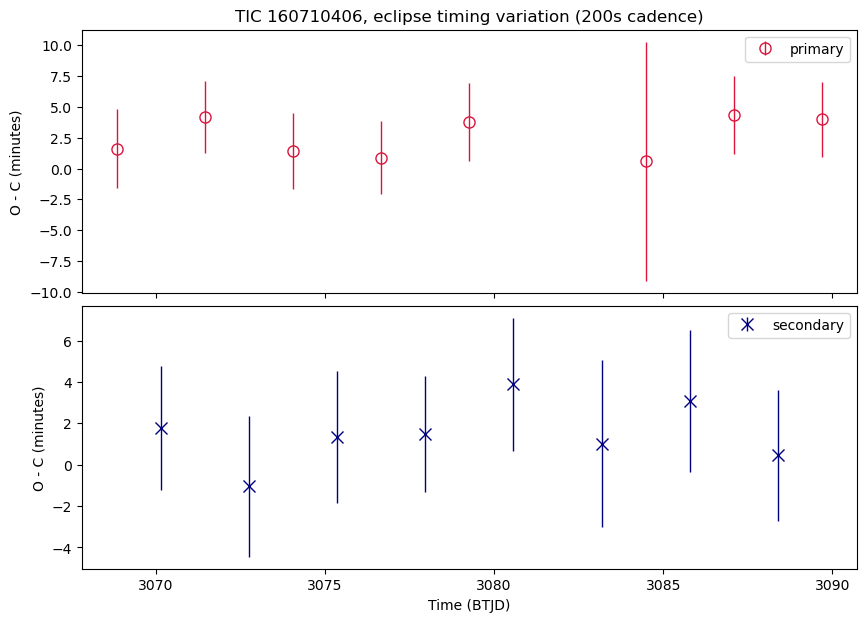

In [162]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    (1500, 1700),
    (2300, 2500),
    (3000, 3200),
]

def tweak_axs_list(axs_list):
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    ax = axs_list[0][0]
    ax.set_title(f"{ax.get_title()} (30min cadence)")
    ax = axs_list[1][0]
    ax.set_title(f"{ax.get_title()} (10min cadence)")
    ax = axs_list[2][0]
    ax.set_title(f"{ax.get_title()} (200s cadence)")

    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5

        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]

        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]

        # axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
        #                marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]

            # axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
            #                marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                            lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();

        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)

        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

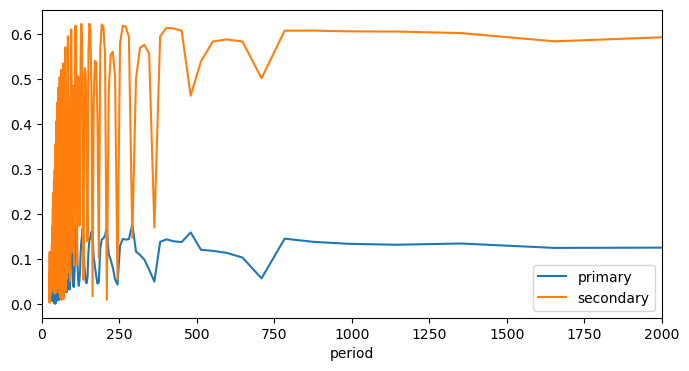

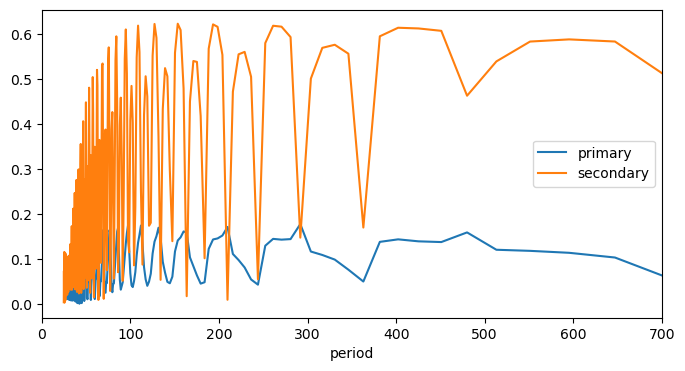

In [163]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')

plt.xlabel("period")

plt.legend()
plt.xlim(0, 2000)
plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))

    plt.plot(1/frequency, power, label = 'primary')

    if t0_secondary is not None:
        plt.plot(1/frequency_s, power_s, label = 'secondary')

    plt.xlabel("period")

    plt.legend()
    plt.xlim(0, 700)
    plt.show()

## O-C plot, folded

- for periodic trend in O-C

In [ ]:
def truncate_freq_power_to_period_range(freq, power, period_min, period_max):
    f, p = freq, power
    if period_min is not None:
        f, p = f[f < 1 / period_min], p[f < 1 / period_min]
    if period_max is not None:
        f, p = f[f > 1 / period_max], p[f >  1 / period_max]
    return f, p


def plot_oc_folded(period_min=None, period_max=None, period_min_s=None, period_max_s=None, period=None, period_s=None):

    if period is None:
        _f, _p = truncate_freq_power_to_period_range(frequency, power, period_min, period_max)
        period = 1 / _f[np.argmax(_p)]
    phase_oc = etv_functions.phase_data(in_df_primary.epoch, 0, period)

    fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y * 1.1), sharex=False)
    if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
        axs = [axs]
    
    axs[0].scatter(phase_oc, in_df_primary.shift_mins, marker = 'o', s=12**2, c=in_df_primary.epoch);
    axs[0].errorbar(phase_oc, in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
                    lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'None', label="primary")
    axs[0].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period:.4f} d", fontsize=14)

    if in_df_secondary is not None:
        if period_s is None:
            _f, _p = truncate_freq_power_to_period_range(frequency_s, power_s, period_min_s, period_max_s)
            period_s= 1 / _f[np.argmax(_p)]
        phase_oc_s = etv_functions.phase_data(in_df_secondary.epoch, 0, period_s)
        axs[1].scatter(phase_oc_s, in_df_secondary.shift_mins, marker = 'o',  s=12**2, c=in_df_secondary.epoch);
        axs[1].errorbar(phase_oc_s, in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color='None', ecolor='navy', markeredgecolor = 'None', label="secondary" );
        axs[1].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period_s:.4f} d", fontsize=14)

    for ax in axs:
        ax.set_ylabel("O - C (minutes)")
        ax.set_xlabel("Phase (Normalized)")
        ax.legend();
    plt.subplots_adjust(hspace=0.4)
    return axs

In [ ]:
%matplotlib inline
# %matplotlib widget

if False:  # plot O-C periodic trend by folding with a period (from LS Periodogram by default)
    def tweak_axs(axs):
        pass

    axs = plot_oc_folded(
        period_min=None, period_max=None,
        period_min_s=None, period_max_s=None
    )
    tweak_axs(axs)

## Results Summary

In [148]:
# FILL-IN the ETV results / comments
has_etv = "N?"
comments = "O-C is only scatter, but significant out of eclipse variation probably distorted the result."

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True,
))

0
tic                                                                                             160710406
has_etv                                                                                                N?
comments     O-C is only scatter, but significant out of eclipse variation probably distorted the result.
period                                                                                            2.60183
depth_pct_p                                                                                           5.3
depth_pct_s                                                                                          4.93
epoch_p                                                                                          1598.832
epoch_s                                                                                       1597.531085
num_sectors                                                                                             3
time_span                                                                                         1497.69
time_start                                                                                        1596.81
time_end                                                                                           3094.5


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
160710406,N?,"O-C is only scatter, but significant out of eclipse variation probably distorted the result.",2.60183,5.3,4.93,1598.832,1597.531085,3,1497.69,1596.81,3094.5

